# Multiclass classification of news articles

# Introduction
## Motivation:

In recent years, the rapid increase in the number of digital news articles has made it increasingly challenging to process and categorise large amounts of information. News articles often span a diverse range of topics, including politics, sports, business, and technology. As the number of online articles continues to rise, effective and automated methods of classifying news into relevant categories have become essential for applications such as personalised news feeds, content recommendations, and information retrieval systems.

Categorisation is a fundamental process for many business. News organisations, in particular, must constantly identify and classify content to track topic coverage and stay aligned with audience interests. Providing the right information at the right time to the right audience is central to their operations. To remain competitive in this environment, investing in automated classification systems powered by neural networks is not only justified, but necessary for long-term efficiency and scalability.

Traditional methods, such as rule-based approaches and simple machine learning algorithms, often struggle to capture the nuanced contexts of multifaceted news articles. Manual categorisation has become impractical, it requires large editorial teams, is time consuming, expensive, and ultimately, unsustainable at scale.

In contrast, recent advances in artificial intelligence, particularly in deep learning, have provided significant improvements in text classification tasks. Deep neural networks, especially models like convolutional neural networks, recurrent neural networks (particularly LSTMs), and transformers, have shown impressive performance on tasks such as sentiment analysis, topic modeling, and document classification. These advancements have proven to be especially useful in classifying news articles into predefined categories.

## Problem Statement:

The goal of this project is to accurately and efficiently assign categories to news articles from the AG News dataset using neural network-based classification models.

The AG News dataset contains thousands of news articles, each labelled with one of four categories: World, Sports, Business, or Science/Technology. Our task is to develop deeper neural network models that can automatically and reliably predict the correct category based on the textual content of each article.

This problem is both practically significant and technically challenging. News articles vary widely in writing style, vocabulary, and topical overlap, making it difficult for traditional rule-based or shallow machine learning methods to perform consistently well. These limitations highlight the need for more sophisticated approaches, particularly deep learning models capable of capturing complex semantic patterns and contextual nuances.

To address this, the project focuses on developing and evaluating a range of neural network architectures, from basic feedforward networks to more advanced models such as CNNs, LSTMs, and transformers. The aim is to explore the strengths and weaknesses of each approach and to determine their suitability for large-scale, real-world news classification.

Throughout the study, two key performance criteria are emphasised:

* Accuracy: The ability of the model to correctly classify news articles with minimal misclassifications. A highly accurate model reliably identifies the topic of an article based on its content.
* Efficiency: The model's computational performance, including training time, memory usage, and the ability to make real-time or near-real-time predictions.

These factors are essential for building scalable and production-ready classification systems, where speed, cost-effectiveness, and accuracy are all critical. Ultimately, this project seeks to identify which neural network models best balance these trade-offs and offer practical solutions for automated news categorisation.




## Import and set up statements

Create the environment and set up functions for our dataset and models

In [ ]:
!pip install datasets wandb torch-summary --quiet
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
folder = '/content/drive/MyDrive/Colab Notebooks/9444'

Mounted at /content/drive


In [ ]:
import os
import re
import string
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    ConfusionMatrixDisplay
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from transformers import AutoModelForSequenceClassification

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
import tensorflow as tf

from transformers import AutoTokenizer

from datasets import load_dataset, DatasetDict, Dataset
import tensorflow_datasets as tfds

import wandb


# os.environ["WANDB_API_KEY"] =

## Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Data and models will be processed on {device}")

Data and models will be processed on cuda:0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## Plotting functions

def plot_results(epochs, train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(12, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='horizontal')
    plt.grid(False)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    # Accuracy
    acc = accuracy_score(all_targets, all_preds)
    print(f"Accuracy: {acc:.4f}")

# **Literative Reivew**

## 1. Before Neural Networks

### Traditional Baseline Models for Text Classification
Before the rise of deep learning, several classical machine learning approaches dominated text classification tasks, setting important baselines that newer models are compared against.

### Naive Bayes Classifier
The Multinomial Naive Bayes model represents one of the simplest yet effective approaches for text classification. This probabilistic classifier applies Bayes' theorem with strong independence assumptions between features, making it particularly suitable for high-dimensional, sparse text datasets. Despite its simplicity, Naive Bayes continues to serve as an important baseline for the AG News dataset due to its computational efficiency and reasonable accuracy ([1] Optimising News Categorisation with Machine Learning, 2024).

### Support Vector Machines (SVM)
SVMs have demonstrated strong performance in text classification by finding optimal hyperplanes that maximise the margin between different text categories. The Stochastic Gradient Descent (SGD) classifier with hinge loss effectively implements SVM and has been applied successfully to the AG News dataset. These models excel at handling high-dimensional feature spaces typical of text data, particularly when coupled with TF-IDF (Term Frequency-Inverse Document Frequency) representations ([2] Multi-category News Classification Using Support Vector Machine Based Classifiers, 2020).

### Decision Tree-Based Models
Decision tree models apply a hierarchical, rule-based approach to text classification by recursively partitioning the feature space. These models learn decision rules directly from text features such as word frequency and key terms. While individual decision trees often underperform compared to other methods, ensemble variations like Random Forests and Gradient Boosting have shown improved performance by combining multiple decision trees to reduce overfitting and increase generalisation capabilities ([3] Kaggle AG News Classification with Classical Models by Aziz Barank, 2021).


## 2. Simple Neural Networks
The introduction of neural networks marked a significant shift in text classification methodologies, offering the ability to learn complex patterns from data.

### Feedforward Neural Networks
Early applications of feedforward neural networks to text classification involved converting text into numerical representations, such as bag-of-words or TF-IDF vectors, and feeding them into multi-layer perceptrons. While these models could capture non-linear relationships, they lacked the ability to account for word order and context, limiting their effectiveness on datasets like AG News ([4] AG News Text Classification by Netra212, 2021).

### Recurrent Neural Networks (RNNs)
RNNs, particularly Long Short-Term Memory (LSTM) networks, addressed the limitations of feedforward networks by introducing mechanisms to capture sequential dependencies in text. By processing input sequences word by word and maintaining a hidden state, RNNs could model the context within sentences, leading to improved performance in text classification tasks ([5] A Novel Approach for Text Classification Using Recurrent Neural Networks, 2023).

## 3. Advanced Neural Networks
Advancements in neural network architectures further enhanced the capabilities of text classification models.

### Convolutional Neural Networks (CNNs)
Originally designed for image processing, CNNs were adapted for text classification by treating text as a one-dimensional sequence. Models like the character-level CNN introduced by Zhang et al. demonstrated that CNNs could effectively capture local features and patterns in text, achieving competitive results on the AG News dataset ([6] Character-level Convolutional Networks for Text Classification, 2015).

### Hybrid Models
Combining different neural network architectures led to hybrid models that leveraged the strengths of each component. For instance, integrating CNNs with RNNs allowed models to capture both local and sequential features in text. Additionally, the development of attention mechanisms enabled models to focus on relevant parts of the input, further improving classification performance ([7] Fake News Detection: A Hybrid CNN-RNN Based Deep Learning Approach, 2020).

## 4. Lastest Architecture of Transformers
The emergence of transformer architectures revolutionised natural language processing, including text classification.

### BERT and Variants
Bidirectional Encoder Representations from Transformers (BERT) introduced a novel approach to pre-training language representations. By considering both left and right context in all layers, BERT achieved state-of-the-art results on various NLP tasks. Fine-tuning BERT on the AG News dataset has led to significant improvements in classification accuracy ([8] AG News BERT Classification by Mansoor Hamidzadeh, Hugging Face, 2021).

### XLNet
XLNet, an extension of BERT, incorporates permutation-based training to capture bidirectional contexts while avoiding the limitations of masked language modeling. This approach has further advanced the performance of text classification models on datasets like AG News ([9] XLNet: Generalised Autoregressive Pretraining for Language Understanding, 2019).

## References
[1] Optimising News Categorisation with Machine Learning, Springer, 2024.

[2] Multi-category News Classification Using Support Vector Machine Based Classifiers, Springer, 2020.

[3] Kaggle AG News Classification with Classical Models, Aziz Barank, 2021.

[4] AG News Text Classification, Netra212, 2021.

[5] A Novel Approach for Text Classification Using Recurrent Neural Networks, ResearchGate, 2023.

[6] Character-level Convolutional Networks for Text Classification, Zhang et al., NeurIPS, 2015.

[7] Fake News Detection: A Hybrid CNN-RNN Based Deep Learning Approach, ScienceDirect, 2020.

[8] AG News BERT Classification, Mansoor Hamidzadeh (Hugging Face), 2021.

[9] XLNet: Generalised Autoregressive Pretraining for Language Understanding, Yang et al., NeurIPS, 2019.


# Data Sources and Data preparation

## Data Source

The project uses the AG News dataset for the classification problem, a  widely-used benchmark in text classification research. The dataset was originally created by Xiang Zhang, Junbo Zhao, and Yann LeCun in their 2015 paper, [Character-level Convolutional Networks for Text Classification](https://https://arxiv.org/abs/1509.01626). It consists of news articles collected from over 2,000 distinct news sources, offering a diverse and realistic corpus for training and evaluating classification models.

We use the [Tensorflow data for AGNews](https://www.tensorflow.org/datasets/catalog/ag_news_subset). We select this version as it provides a centralised and trusted space to consistently pull source data from. This version includes structured records for each article, with fields for:
* Label: The target cateogry (encoded as an integer from 0 to 3)
* Title: The headline of the news article
* Description: A short summary or snippet from the article

There are 127.6K records where 120k are train, and the remaining 7.6k are set as train. All categories have identical train and test splits (30000, 1900)

<br>

Example entries from the AGNews dataset.

| Title                    | Description | Category | Row Count |
|--------------------------|-------------|----------|-----------|
| Apple launches new chip for Macs | The company announced its new M3 chip at today's event... | Sci/Tech | 30000 (Train) - 1200 (Test)
| US stocks rise after inflation data | Markets rallied as inflation numbers came in lower than... | Business | 30000 (Train) - 1200 (Test) |
| Champions League: Madrid advances | Real Madrid secured a spot in the final after beating... | Sports | 30000 (Train) - 1200 (Test) |
| UN summit on climate begins in NY | Leaders from around the world gather to discuss climate... | World | 30000 (Train) - 1200 (Test) |




<br>

The dataset categorieses each of these articles into four categories:
* World
* Sports
* Business
* Science / Technology

<br>

The dataset is ideal for this project due to its:
* Clean and consistent structure
* Balanced class distribution
* High relevance to real-world news classification challenges
* Established use as a benchmarking tool for text classification models

It enables consistent and reproducible training, validation, and evaluation across different neural network architectures.

<br>

Challenging aspects were also however noted, with some of these in the dataset being:

| Challenge                 | Description |
|--------------------------|-------------|
| **Category Overlap**     | News articles often span multiple topics (e.g., tech + business), making it hard to assign a single label. |
| **Limited Context**      | Titles and short descriptions can lack the depth needed for confident classification. |
| **Language Ambiguity**   | Phrasing, synonyms, and sentence structure vary widely across articles. |
| **Subtle Differences**   | Small changes in wording can shift an article from one category to another. |
| **Noisy Input**          | Presence of stop words and non-informative boilerplate text without preprocessing. |
| **Computational Constraints** | Training deep learning models on large datasets requires significant memory, processing power, and time — posing challenges for tuning, experimentation, and deployment. |



# Data Preperation
We prepare the data applying a basic tokenizer [bert uncased](https://huggingface.co/google-bert/bert-base-uncased) to both original and cleaned text.

Original text contains all stop words, punctuation, html and other characters that can lead to confusing interpretation of the data

Cleaned text removes all html, stop words and puntucation to make the final text purely words.

We apply these transformations as a one off and save the tranformed dataset into a google drive to save time and computation.




## Once off transformation

This section of code only needs to be run ONCE. The transformed dataset will be saved locally (on drive) to allow for future runs of the code to be streamlined. I.e. you **do not** need to run this after the creation of the augemented dataset

In [ ]:
## Define all transformation functions

stop_words = stopwords.words()

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return {"label_list": np.eye(num_classes, dtype='int64')[y]}

def pad_text(text, pad_token="<PAD>", max_sequence=100):
  return {"text_pad": " ".join([text] + [pad_token] * (max_sequence - len(text)))}

def remove_urls(content):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return {"content": url_pattern.sub(r'', content)}

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return {"content": html_pattern.sub(r'', text)}

def word_tokenize(txt):
    tokens = re.findall("[\w']+", txt)
    return {"content": tokens}

def filter_out_stopwords(tokens):
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.append(token)
    return {"content": filtered_tokens }

def remove_meaningless_tokens(tokens):
    stop_tokens = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com', 'u']
    new_tokens = []
    for token in tokens:
        if token not in stop_tokens:
            new_tokens.append(token)
    return {"content": new_tokens }

def remove_digits(tokens):
    no_digits_tokens = []
    new_tokens = []

    for token in tokens:
        for digit in string.digits:
            token = token.replace(digit, '')
        no_digits_tokens.append(token)

    for token in no_digits_tokens:
        if token != '':
            new_tokens.append(token)

    return {"content": new_tokens}

def preprocess_text(text):
    text = str(text).lower()
    text = text.replace('$', 'dollar')\
               .replace(',000,000', 'm').replace('000', 'k')\
               .replace("won't", 'will not').replace("can't", 'can not')\
               .replace("shouldn't", 'should not').replace("what's", '"what is"')\
               .replace("that's", 'that is').replace("he's", 'he is')\
               .replace("she's", 'she is').replace("it's", 'it is')\
               .replace("'ve", ' have').replace("'re", ' are')\
               .replace("'ll", ' will').replace("i'm", 'i am')\
               .replace("n't", " not")
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    return {"content": text}

def tfds_to_list(tf_data):
  return [{"split":row['split'].numpy().decode('utf-8'), "description":row['description'].numpy().decode('utf-8'), "title":row['title'].numpy().decode('utf-8'), "text": (row["title"] + " " + row["description"]).numpy().decode('utf-8'), "label": int(row['label'].numpy())} for row in tf_data]

def add_split(example, split_name):
    example['split'] = tf.constant(split_name)
    return example

train_data, test_data = tfds.load(
    'ag_news_subset',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=False  # returns (text, label) pairs
)

train_data = train_data.map(lambda x: add_split(x, 'train'))
test_data = test_data.map(lambda x: add_split(x, 'test'))

train_list = tfds_to_list(train_data)
test_list = tfds_to_list(test_data)

hf_dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(train_list)),
    'test': Dataset.from_pandas(pd.DataFrame(test_list))
})

In [ ]:
# Once off transformation

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
dataset = hf_dataset_dict.map(lambda e: tokenizer(e['text'], padding='max_length', max_length=100, truncation=True), batched=True, num_proc=48)

dataset = dataset.map(lambda e: to_categorical(e['label'], 4), num_proc=48)
dataset = dataset.map(lambda e: pad_text(e['text']), num_proc=48)

dataset = dataset.rename_column("input_ids", "original_input_ids")
dataset = dataset.rename_column("text_pad", "original_text_pad")
dataset = dataset.rename_column("title", "original_title")

# Apply clean up transformations
dataset = dataset.map(lambda e: {"content": e['text']}, batched=True)
dataset = dataset.map(lambda e: preprocess_text(e['content']),num_proc=48)
dataset = dataset.map(lambda e: remove_urls(e['content']), num_proc=48)
dataset = dataset.map(lambda e: remove_html(e['content']),num_proc=48)
dataset = dataset.map(lambda e: word_tokenize(e['content']),num_proc=48)
dataset = dataset.map(lambda e: filter_out_stopwords(e['content']),num_proc=48)
dataset = dataset.map(lambda e: remove_meaningless_tokens(e['content']),num_proc=48)
dataset = dataset.map(lambda e: remove_digits(e['content']), num_proc=48)
dataset = dataset.map(lambda e: tokenizer(" ".join(e['content']), padding='max_length', max_length=100, truncation=True), num_proc=24)

dataset.save_to_disk('/content/drive/MyDrive/Colab Notebooks/9444/ag_news_processed_300')

## Create dataset

This can be run if the prior once off transformation has been run.
This imports the dataset and uses the pytorch dataloader for training and test purposes

In [ ]:

train_batch = 100
test_batch = 1000

## Label Maps
label_map = {0:"world", 1: "sports", 2:"business", 3:"sci/tech"}
label_map_arr = list(label_map.values())
label_integer_map = list(label_map.keys())

## Load data
dataset = DatasetDict.load_from_disk('/content/drive/MyDrive/Colab Notebooks/9444/ag_news_processed')

## Convert the tensors to torch type, so dataloader can easily measure the length
### There is an issue if you try and include text in here
dataset.set_format(type='torch', format_kwargs={'dtype': torch.long}, columns=['original_input_ids', 'input_ids', 'label_list'])

## Split into test train
trainSet = DataLoader(dataset['train'], batch_size=train_batch, shuffle=True )
testSet = DataLoader(dataset['test'], batch_size=test_batch, shuffle=False)


Creating an alternate view of the dataset to help stremaline the data analysis process.

In [ ]:
train_df = dataset['train'].to_pandas()
train_df['source'] = 'train'

test_df = dataset['test'].to_pandas()
test_df['source'] = 'test'

analysis_df = pd.concat([train_df, test_df])

labels = {0:'World',
          1:'Sports',
          2:'Business',
          3:'Science'}

analysis_df['labels'] = analysis_df['label'].map(labels)

## Train, test, eval function creation
Define a train, test and eval function to rapid model development and logging

In [ ]:
## Create training functions:
def train(trainSet, model, train_column='original_input_ids', target_column = 'label_list', train_type=torch.long, target_type=torch.float32, device=device):
  running_loss = 0.0
  for i, data in enumerate(trainSet):
      inputs, labels = data[train_column], data[target_column]
      inputs = inputs.to(train_type).to(device)
      labels = labels.to(target_type).to(device)

      #Start Training
      optimizer.zero_grad()
      outputs = model(inputs)

      ## For Hugging Face Model only
      if "config" in list(model.__dict__.keys()):
        outputs = outputs[0] ## The classification produces a tuple, we need the logits.
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      # print statistics
      if i % 100 == 0:
        print(f'Batch iteration:{i}: {i*1000}/{len(trainSet.dataset)}. loss: {loss.item()}')

  return model, running_loss

def test(testSet, model, train_column='original_input_ids', target_column = 'label_list', train_type=torch.long, target_type=torch.float32, device=device):
  correct = 0
  with torch.no_grad():
    model.eval()
    val_loss = 0.0

    for i, test_data in enumerate(testSet):

      test_inputs, test_labels = test_data[train_column], test_data[target_column]
      test_inputs = test_inputs.to(train_type).to(device)
      test_labels = test_labels.to(target_type).to(device)

      y_pred = model(test_inputs)
      val_loss += criterion(y_pred, test_labels)

      # reformat for accuracy
      pred = y_pred.argmax(dim=1, keepdim=True)
      test_label_formatted =  test_labels.argmax(dim=1, keepdim=True)

      #accuracy
      correct += pred.eq(test_label_formatted).sum().item()

    print(f"loss: {val_loss}")
    print(f"correct: {correct}")
    print(f"len: {len(testSet.dataset)}")
    accuracy = (correct/len(testSet.dataset))*100.00
    print(f"Accuracy: {accuracy}%")
    wandb.log({"test-accuracy":accuracy, "test-loss": val_loss})

  model.train()

def evaluate_model(testSet, model, train_column='original_input_ids', target_column = 'label_list', train_type=torch.long, target_type=torch.float32, device=device):
  correct = 0
  with torch.no_grad():
    model.eval()
    val_loss = 0.0
    collect_pred = []
    collect_label = []

    for i, test_data in enumerate(testSet):

      test_inputs, test_labels = test_data[train_column], test_data[target_column]
      test_inputs = test_inputs.to(train_type).to(device)
      test_labels = test_labels.to(target_type).to(device)

      y_pred = model(test_inputs)
      val_loss += criterion(y_pred, test_labels)

      # reformat for accuracy
      pred = y_pred.argmax(dim=1, keepdim=True)
      test_label_formatted =  test_labels.argmax(dim=1, keepdim=True)

      #accuracy
      correct += pred.eq(test_label_formatted).sum().item()

      pred = pred.detach().squeeze().to('cpu').numpy()
      test_label_formatted = test_label_formatted.detach().squeeze().to('cpu').numpy()

      collect_pred = np.concatenate([collect_pred, pred])
      collect_label = np.concatenate([collect_label, test_label_formatted])

    print(f"Eval loss: {val_loss}")
    accuracy = (correct/len(testSet.dataset))*100.00
    #Accuracy:
    print(f"Eval accuracy: {accuracy}%")
    wandb.log({"eval-accuracy":accuracy, "eval-loss": val_loss})

  # Confusion Matrix
  wandb.log({"conf_id" :wandb.plot.confusion_matrix(
              preds=collect_pred, y_true=collect_label, class_names=list(label_map_arr))})

  #recall
  recall = recall_score(collect_label, collect_pred, labels=label_integer_map, average='weighted')
  print(f"Eval recall: {recall}")
  wandb.log({"eval-recall":recall})

  # Precision:
  precision = precision_score(collect_label, collect_pred,labels=label_integer_map, average='weighted')
  print(f"Eval precision: {precision}")
  wandb.log({"eval-precision":precision})

  # F1 Score
  f1_score_ = f1_score(collect_label, collect_pred,labels=label_integer_map, average='weighted')
  print(f"Eval f1_score: {f1_score_}")
  wandb.log({"eval-f1_score":f1_score_})
  return collect_pred, collect_label


# Data analysis

An initial exploration, before any data processing, of the content length (measured in word count) across both training and test sets reveals that their distributions are highly consistent. The density plots show a similar shape and range, with most samples clustering around a moderate length, and few extreme outliers. This uniformity suggests that the model will not face significant generalisation issues caused by length disparity between training and test data.

A majority of the data has a content length ~200 words. The content length distributions between the train and test set, and all label types is quite consistent, having minimal KL-divergence between the sets. After text processing and tokenization we find that the mean content length reduces to ~34 words and ~50 tokens.

To further validate the similarity between the datasets, we computed the KL divergence between the content length distributions of the training and test sets, both before and after preprocessing.

* Pre-processing: The KL divergence is low, indicating that the raw content length distributions are closely aligned.
* Post-processing: After steps such as lowercasing, stopword removal, and punctuation stripping, the divergence remains low. This confirms that the preprocessing pipeline preserves the structural consistency between the datasets.

This stability is crucial, as it ensures that any improvements or changes observed during training are less likely to be artifacts of preprocessing-induced distributional shifts.

<br>

![PostProcess_KL-Divergence](https://drive.google.com/thumbnail?&id=1K23aKFTsodp98l0aXhqmw8UyhmnlQdbn&sz=s7000)


The label distribution across the four AG News categories is perfectly balanced in both the training and test datasets. Each class (World, Sports, Business, Sci/Tech) has an equal representation. This balance eliminates the need for data augmentation techniques or class reweighting, simplifying the modeling process and reducing the risk of bias toward any particular class.

<br>

![Label_Distribution](https://drive.google.com/thumbnail?&id=1WnpOwVKwSoTuQU0rXSyeM4AoZ-9tGQnq&sz=s7000)

We also visualise word clouds before and after preprocessing to assess how the vocabulary changes:

* Pre-processing: The raw word clouds are cluttered with common stop words (e.g., the, is, at, and), which do not contribute meaningful information for classification. These frequent but semantically shallow terms dominate the visual space, masking the more informative words.

* Post-processing: After stopword removal, the word clouds highlight content-rich tokens more clearly. These terms are far more valuable in distinguishing between categories, particularly for neural models that rely on semantic content.

Removing stopwords not only improves the clarity of the vocabulary space but also reduces noise for the models, helping them focus on discriminative features during training.

When analysing the frequency of words throughout the test and train set we note time references such as week and year and brands such as Reuters appear along side day names like "Wednesday" and "Tuesday".

<br>

![Word Analysis](https://drive.google.com/thumbnail?&id=1cQ_HpWttzEHn3LpSEFD908oitmd79CJe&sz=s1000)

<br>

To better understand the lexical patterns present in the AG News dataset, we analysed the most frequent unigrams (1-grams), bigrams (2-grams), and trigrams (3-grams) in the text data. This helps identify common phrases, collocations, and domain-specific terminology that may be important for classification. We wanted to understand whether certain labels contain specific words that might provide hints to their classification. Running a similary frequency exercise using n-grams across the labels we can see the following.

![ngrams-3](https://drive.google.com/thumbnail?&id=1LccKzdTNyDwlG1plbX0aRoE5KfIz7C5l&sz=s1000)


Unigrams (1-grams):
Before preprocessing, the most common unigrams include high-frequency stopwords such as the, is, at, and on. These words, while syntactically essential, carry little discriminatory power for categorising news articles.
After preprocessing, the most frequent unigrams shift toward content-rich terms like president, market, team, and technology. These tokens are much more informative and relevant for distinguishing between topics such as Business or World News.

Bigrams (2-grams):
Common bigrams before cleaning include generic phrases like in the, of the, or on the. Post-cleaning, we observe more meaningful domain-specific phrases such as stock market, prime minister, football team, and space shuttle. These combinations provide valuable context and improve the model's ability to capture short-range dependencies between words.

Trigrams (3-grams):
While less frequent overall, trigrams can reveal structured patterns in news reporting, such as new york times, united states government, or world health organisation. After stopword removal, the remaining trigrams better reflect entity names or compound concepts, which can be particularly useful for models like CNNs or transformers that benefit from capturing multi-word expressions.

The transition from generic to meaningful n-grams after preprocessing reinforces the value of cleaning the text, especially for classification tasks. It ensures the model's input features are rich in signal and less contaminated by noise, boosting its capacity to learn class-specific language patterns.


### **All visualisations can be seen below in the code plus further visualisations which are not referenced explicity here.**

This data analysis allowed us to gain a deeper understanding of the AG News dataset by examining content length distributions, class balance, and the impact of preprocessing steps such as stopword removal. Through KL divergence analysis, we confirmed the consistency between training and test set distributions, supporting the dataset's suitability for model evaluation. Additionally, insights from n-gram frequency patterns and word cloud visualisations highlighted the importance of textual structure and meaningful token retention, helping us optimise feature representations for downstream classification tasks.

This provided several key benefits:

1. Informed Preprocessing Decisions: By visualising word clouds and analysing n-gram patterns, we ensured that stopword removal and tokenisation preserved the most informative features for classification.

2. Model Robustness: Verifying that content length and label distributions were consistent across splits reduced the risk of data leakage and overfitting, improving model generalisation.

3. Avoided Unnecessary Augmentation: Confirming class balance and distribution similarity between training and test sets meant we could skip potentially harmful or redundant data augmentation.

4. Feature Engineering Guidance: The n-gram analysis guided vocabulary selection and embedding strategies by highlighting the most frequent and meaningful word combinations in the dataset.


## Data Analysis Scripts

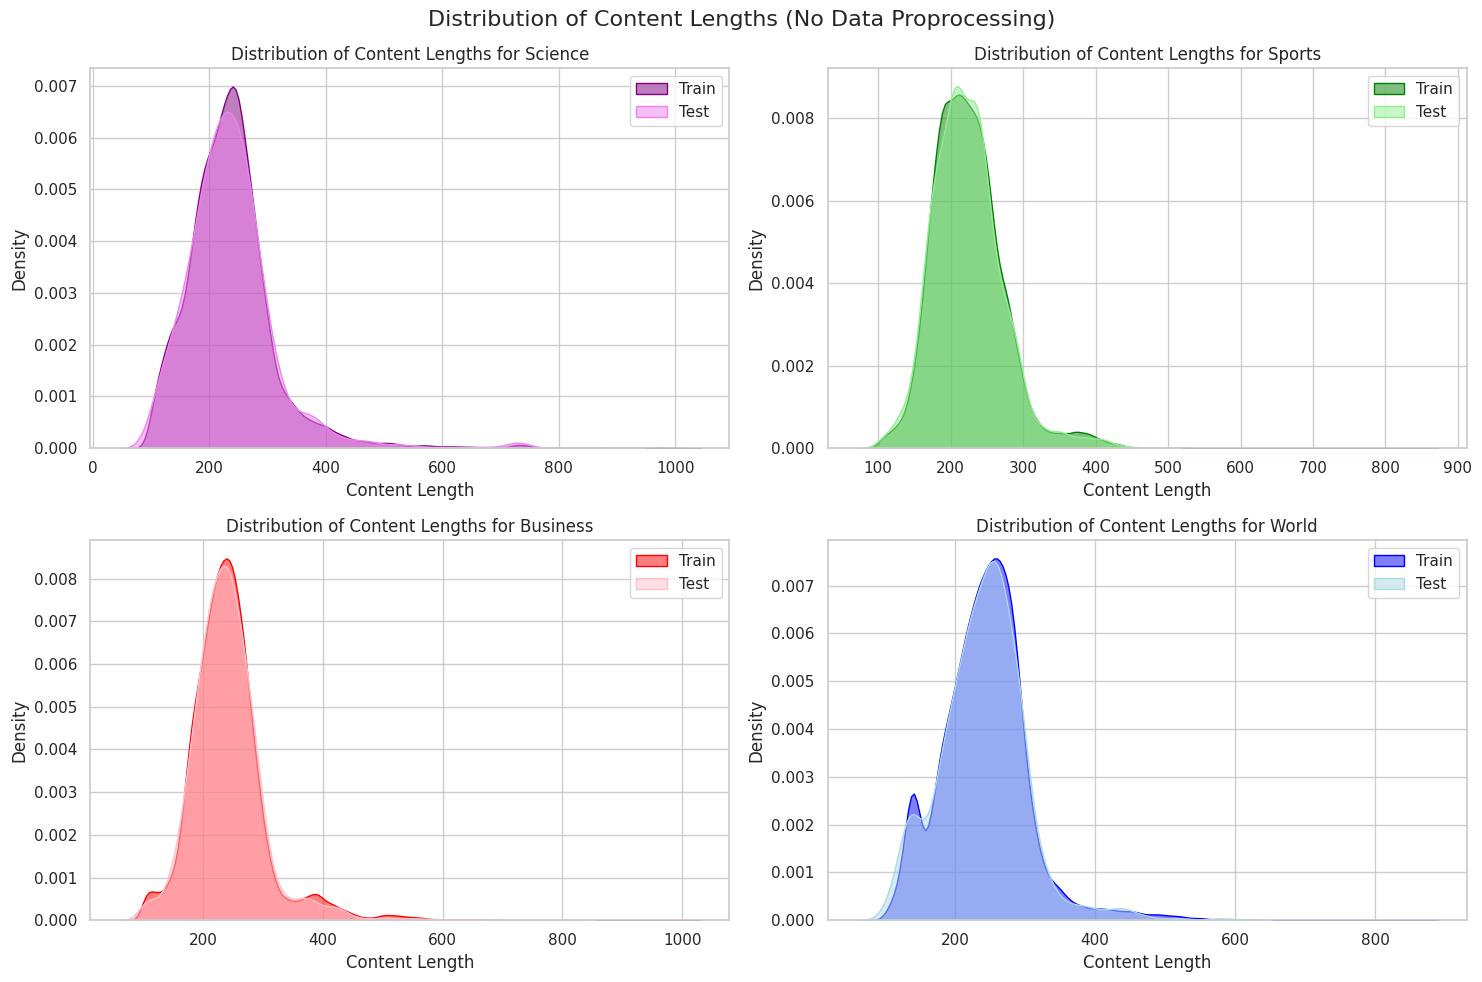

,Label,KL Divergence
0,Science,0.003209
1,Sports,0.001014
2,Business,0.000870
3,World,0.002069


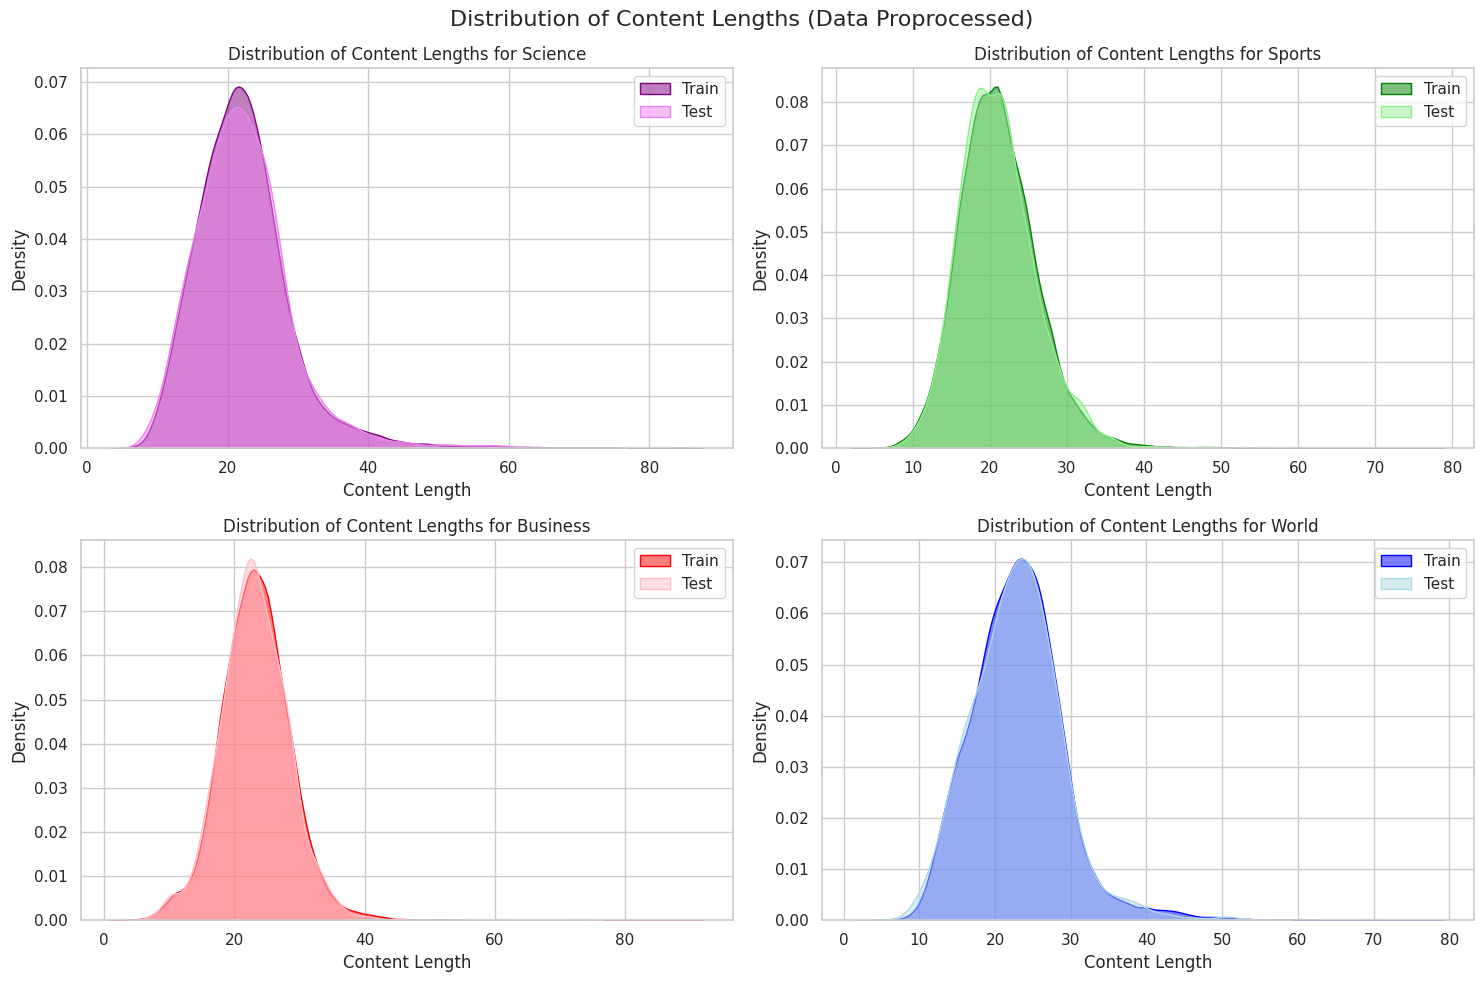

,Label,KL Divergence
0,Science,0.022583
1,Sports,0.019007
2,Business,0.021530
3,World,0.017614


In [ ]:
from scipy.special import kl_div

def plot_and_compare_distributions(df, preprocessed=False, palette=None):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    label_values = df['labels'].unique()

    title = "Distribution of Content Lengths"
    if preprocessed:
        field = "content"
        title += " (Data Proprocessed)"
    else:
        field = "text"
        title += " (No Data Proprocessing)"

    kl_divergences = []

    for i, label in enumerate(label_values):
        subset = df[df['labels'] == label]

        train_lengths = subset[subset['source'] == 'train'][field].str.len()
        test_lengths = subset[subset['source'] == 'test'][field].str.len()

        train_color = palette.get(label, 'blue')
        test_color = palette.get(label + '_test', 'orange')

        sns.kdeplot(train_lengths, ax=axes[i], label='Train', fill=True, alpha=0.5, color=train_color)
        sns.kdeplot(test_lengths, ax=axes[i], label='Test', fill=True, alpha=0.5, color=test_color)

        axes[i].set_title(f"Distribution of Content Lengths for {label}")
        axes[i].set_xlabel("Content Length")
        axes[i].set_ylabel("Density")
        axes[i].legend()

        min_len = min(train_lengths.min(), test_lengths.min())
        max_len = max(train_lengths.max(), test_lengths.max())
        bins = np.linspace(min_len, max_len, 50)

        train_hist, _ = np.histogram(train_lengths, bins=bins, density=True)
        test_hist, _ = np.histogram(test_lengths, bins=bins, density=True)

        train_hist = np.where(train_hist == 0, 1e-10, train_hist)
        test_hist = np.where(test_hist == 0, 1e-10, test_hist)

        kl_divergence = np.sum(kl_div(train_hist, test_hist))
        kl_divergences.append([label, kl_divergence])

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    kl_df = pd.DataFrame(kl_divergences, columns=['Label', 'KL Divergence'])
    display(kl_df)

palette = {
    'World': 'blue',
    'World_test': 'lightblue',
    'Sports': 'green',
    'Sports_test': 'lightgreen',
    'Business': 'red',
    'Business_test': 'pink',
    'Science': 'purple',
    'Science_test': 'violet'
}

plot_and_compare_distributions(analysis_df, preprocessed=False, palette=palette)
plot_and_compare_distributions(analysis_df, preprocessed=True, palette=palette)

In [ ]:
## Basic investigation
import re
import pandas as pd
from urllib.parse import urlparse

def unique_characters(df, column_name):
    all_characters = set()

    # Collect all non-English characters from the entire column
    for value in df[column_name]:
        non_characters = set(re.findall(r"[^\w\s]", str(value)))
        all_characters.update(non_characters)
    return all_characters

rows_urls = analysis_df['text'].apply(lambda x: bool(urlparse(x).scheme)).sum()

print("Number of rows containing URLs:", rows_urls)

all_characters = unique_characters(analysis_df, 'text')
print("Non-English characters:", all_characters)


Number of rows containing URLs: 4788
Non-English characters: {'&', '.', '\\', '-', '(', '=', ':', ';', '/', ')', '*', '$', '"', '?', ',', "'", '!', '#'}


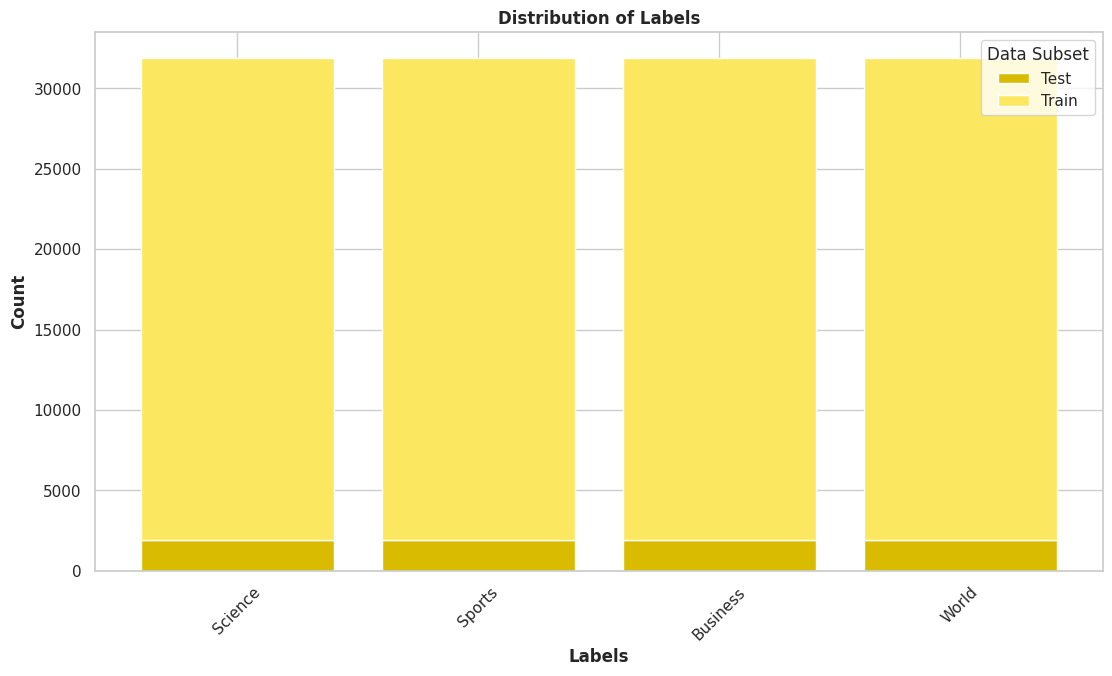

In [ ]:
plt.figure(figsize=(13, 7))
ax = sns.histplot(data=analysis_df, x='labels', hue='source', multiple="stack",
                 palette={'train': '#fce860', 'test': '#d9bc02'},
                 shrink=.8, alpha=1)

plt.legend(["Test", "Train"], title="Data Subset")

plt.title('Distribution of Labels', fontweight='bold')
plt.xlabel('Labels', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [ ]:

analysis_df['content_str'] = analysis_df['content'].apply(lambda x: ' '.join(x))
raw = ' '.join(analysis_df['text'].values)
all_descriptions = ' '.join(analysis_df['content_str'].values)

In [ ]:
# Wordcloud for the most frequent words
def wordcloud_plotter(
    text,
    title="Word Cloud",
    width=1000,
    height=600,
    colormap='Set1',
    background_color='#D3D3D3',
    stopwords=None,
    random_state=42
):
    if stopwords is None:
        stopwords = WordCloud().stopwords  # Use default stopwords

    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color=background_color,
        colormap=colormap,
        stopwords=stopwords,
        random_state=random_state
    ).generate(text)

    plt.figure(figsize=(width/100, height/100))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout(pad=0)
    plt.show()


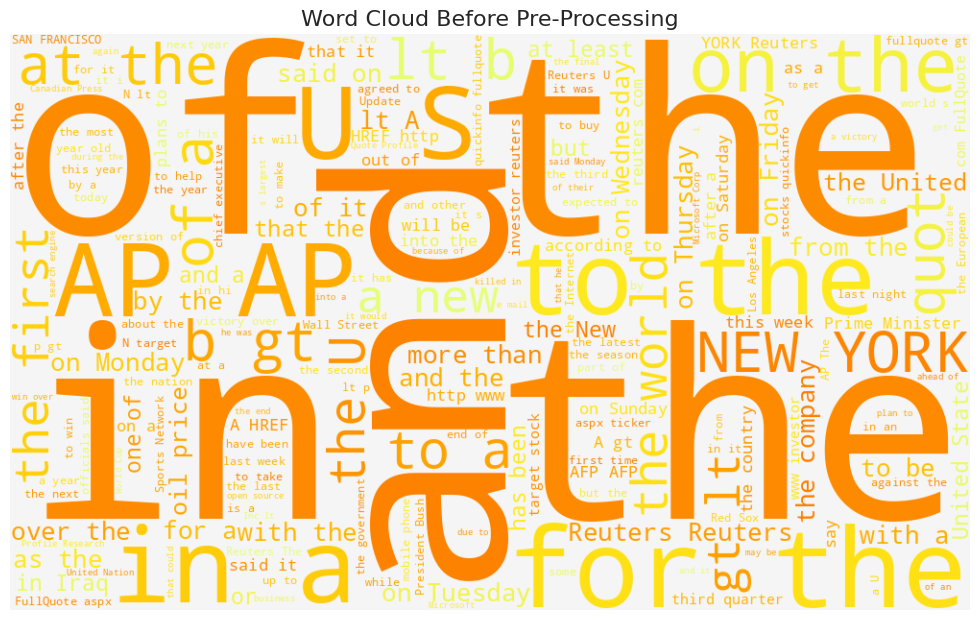

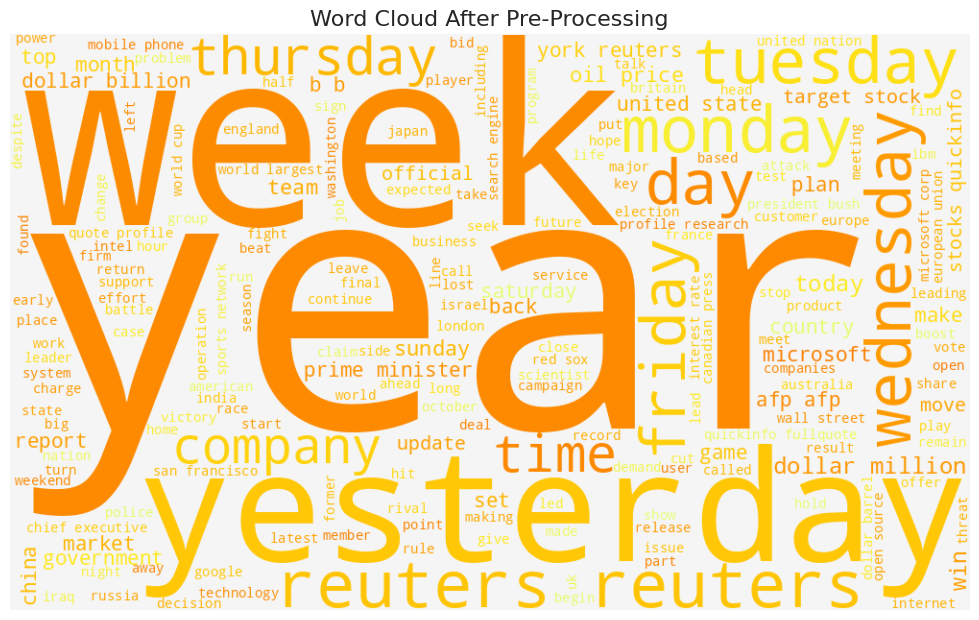

In [ ]:
wordcloud_plotter(raw, title="Word Cloud Before Pre-Processing", width=1000, height=600, colormap='Wistia_r', background_color='#f5f5f5', stopwords=set())
wordcloud_plotter(all_descriptions, title="Word Cloud After Pre-Processing", width=1000, height=600, colormap='Wistia_r', background_color='#f5f5f5', stopwords=set())

In [ ]:
word_counter = Counter(' '.join(analysis_df['content_str']).split())

most_common = 100
top_words = dict(word_counter.most_common(most_common))
df_top_words = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency'])

fig = px.treemap(df_top_words, path=['Word'], values='Frequency', width=1200, height=700,
                 color_continuous_midpoint=0.5, color_continuous_scale='YlOrRd',
                 title='Top 100 Most Frequent Words in Dataset',
                 labels={'Frequency': 'Frequency', 'Word': 'Word'})

fig.update_layout(title_x=0.5, title_font=dict(size=20), font_family='Arial',
                  margin=dict(t=100, b=0, l=0, r=0))

fig.update_traces(textinfo="label+value")
fig.show()

labels = analysis_df['labels'].unique()

for label in labels:
    subset_df = analysis_df[analysis_df['labels'] == label]

    all_content_str = ' '.join(subset_df['content_str'].values)

    word_counter = Counter(all_content_str.split())
    top_words = dict(word_counter.most_common(100))
    df_top_words = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency'])

    # Create and display the treemap
    fig = px.treemap(df_top_words, path=['Word'], values='Frequency',
                     width=1200, height=700,
                     color_continuous_midpoint=0.5, color_continuous_scale='YlOrBr',
                     title=f'Top 100 Most Frequent Words for {label}',
                     labels={'Frequency': 'Frequency', 'Word': 'Word'})

    fig.update_layout(title_x=0.5, title_font=dict(size=20), font_family='Arial',
                      margin=dict(t=100, b=0, l=0, r=0))

    fig.update_traces(textinfo="label+value")
    fig.show()

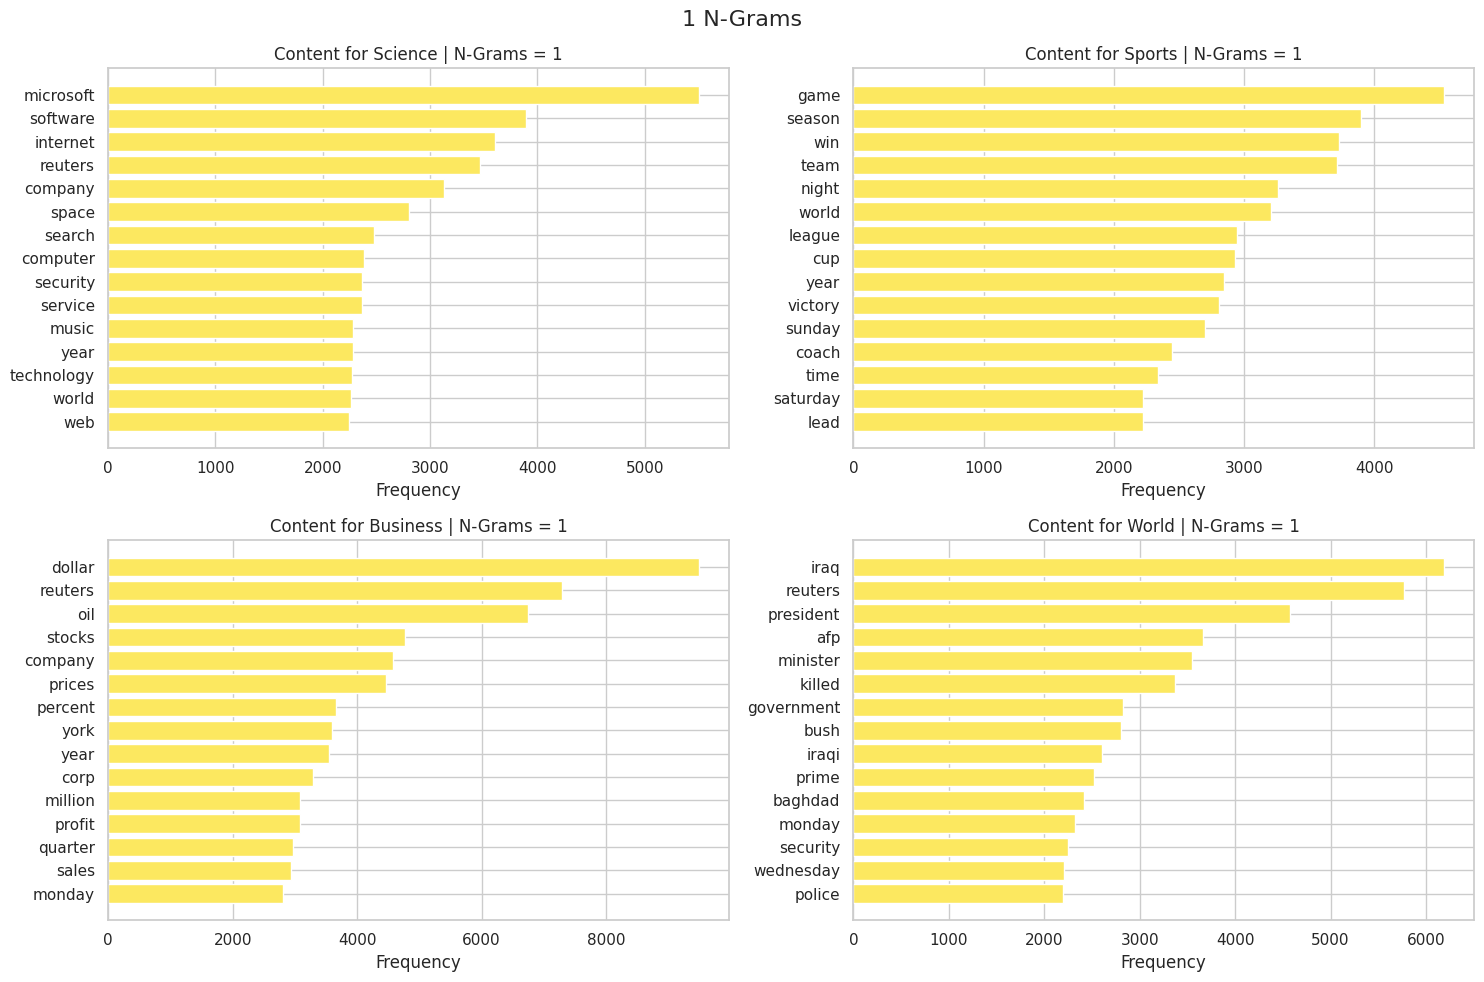

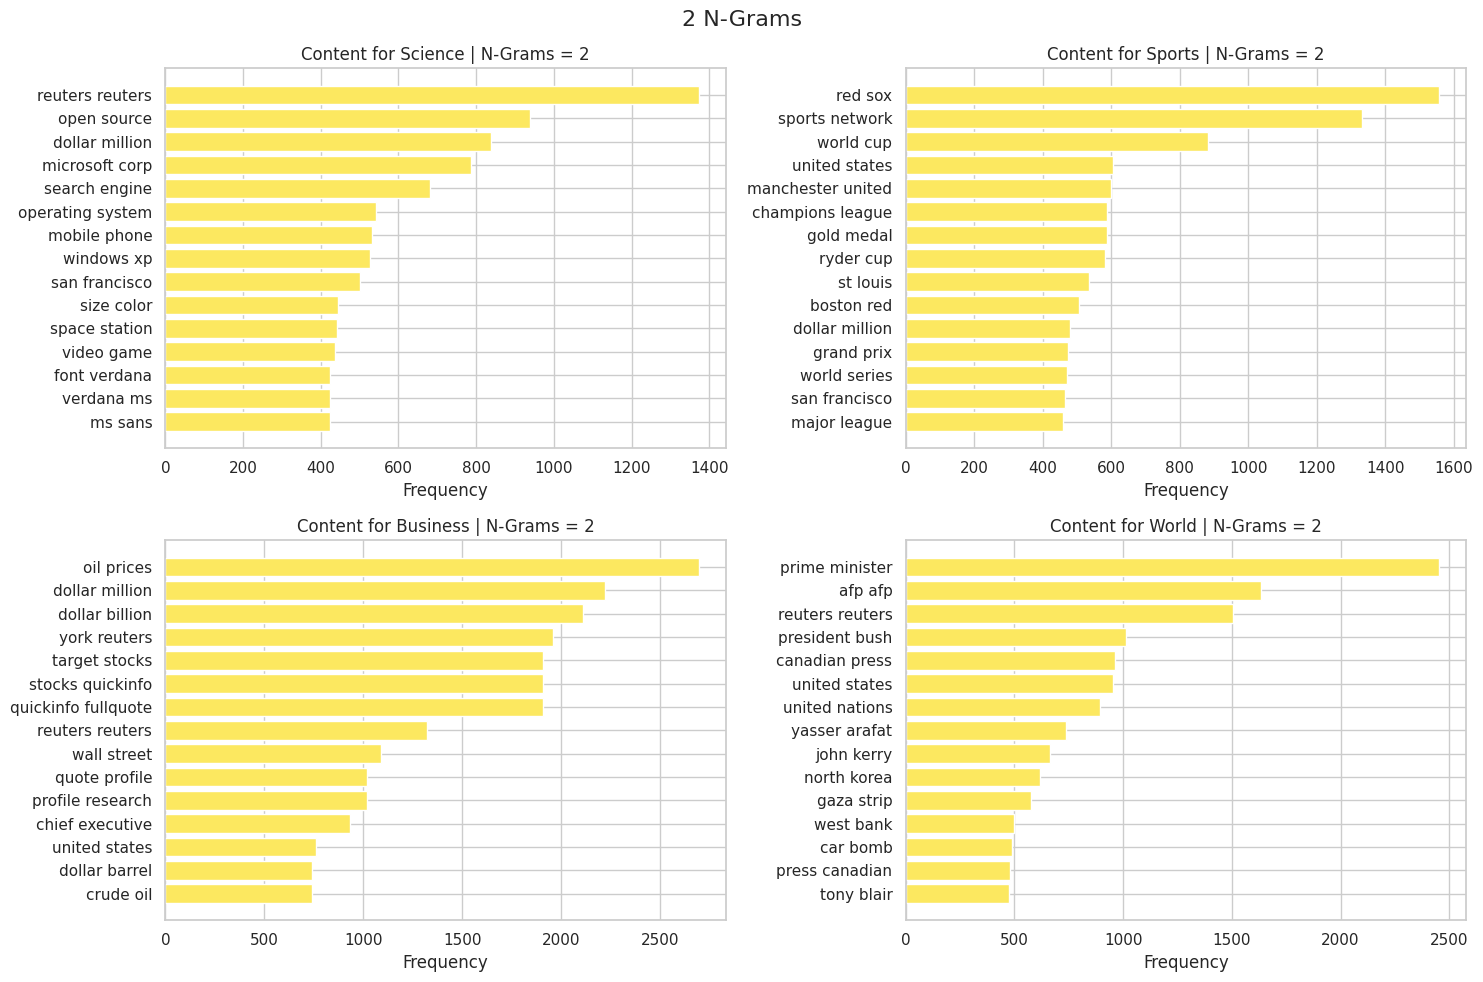

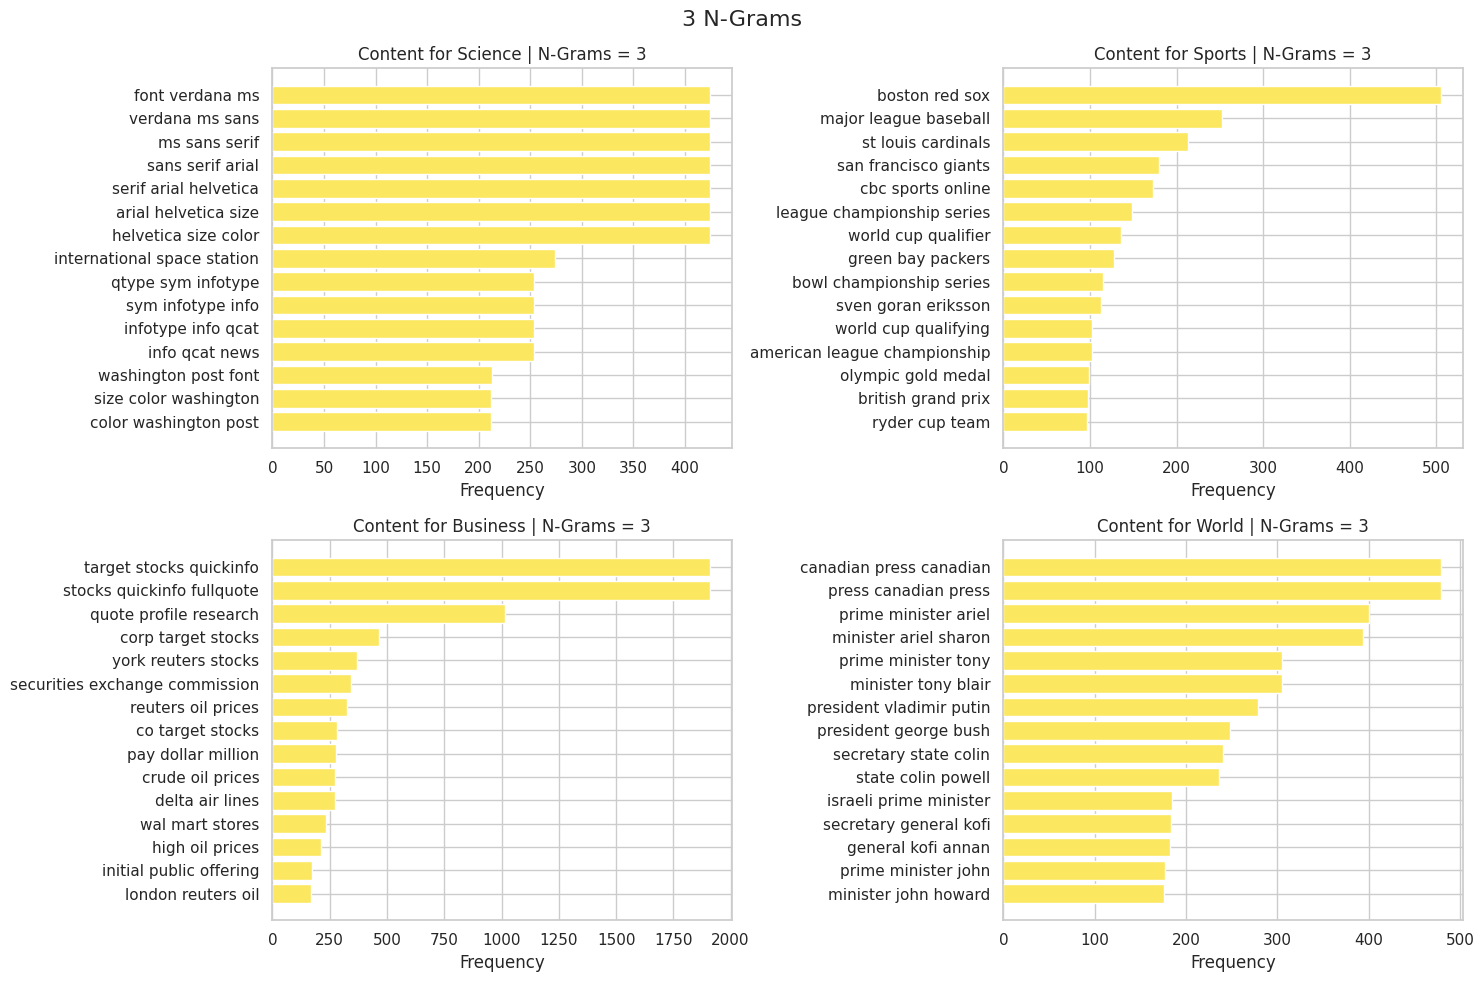

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, n=10, g=2, text_type="Top N-grams", ax=None):
    corpus = [str(doc) for doc in corpus]

    vec = CountVectorizer(ngram_range=(g, g))
    bag_of_words = vec.fit_transform(corpus)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(ngram, sum_words[0, idx]) for ngram, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    ngrams, counts = zip(*words_freq)
    ax.barh(ngrams[::-1], counts[::-1], color='#fce860')
    ax.set_xlabel("Frequency")
    ax.set_title(text_type)

labels = analysis_df['labels'].unique()
n_grams = [1, 2, 3]

for n_gram in n_grams:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create 2x2 grid
    axes = axes.ravel() # Flatten for easy iteration

    for i, label in enumerate(labels):
        label_df = analysis_df[analysis_df['labels'] == label]
        plot_top_ngrams(label_df['content_str'], 15, n_gram,
                        f"Content for {label} | N-Grams = {n_gram}", ax=axes[i])

    fig.suptitle(f'{n_gram} N-Grams', fontsize=16)
    plt.tight_layout()
    plt.show()

# Method / Models

# Practical Benchmarks

We start to investigate the classification problem set using a range of traditional and contemporary benchmark.

We explore Naive Bayes as a classification tool, and zero shot classification using a range of large language models (LLMs).

Where prior papers compare between a variety of deep learning architecture, we aim to benchmark with ubiquitious model and techniques such as zero shot classification using existing LLMs, and efficient techniques such as Naive Bayes.

## Understanding N-Shot Classification
N-shot classification is a task framework that evaluates a model's ability to generalise with limited examples per class. It is especially relevant in low-resource scenarios or when fine-tuning is impractical. In this framework:

Zero-shot classification means the model receives only a textual description of each class label and must classify without any example-specific training. It relies entirely on the model's pretrained knowledge and understanding of label semantics.

One-shot classification introduces a single labeled example for each class. This small amount of in-context learning allows the model to associate content and label more directly.

This evaluation setup is especially relevant for large language models like Gemma, Gemini, and DeepSeek, which are pretrained on broad corpora. While they can recognise a wide range of topics, their ability to distinguish subtle differences, such as between Business and Tech, often improves with even minimal context.

In our benchmarks, we compare Naive Bayes with zero- and one-shot variants of LLMs to examine the trade-off between classical supervised learning and modern general-purpose models with minimal supervision.

## Summary:
The Naive Bayes method produces a practical method that exceed the zero shot classificaiton techniques using existing LLMs.

The accuracy over the test set for Naive bayes is 90%, where as, for the zero shot techniques, only a maximum accuruacy of 88.6% is produced.

| Base Model        | Extension | Accuracy | Precision | F1-Score |
|------------------|-----------|----------|-----------|----------|
| Naïve Bayes      | -         | 90.00%   | 90.0%     | 90.0%    |
| **Gemma 3: 12B** | Zero-Shot | 83.70%   | 85.20%    | 83.30%   |
|                  | One-Shot  | 84.50%   | 85.20%    | 84.40%   |
| **Gemini 2.5 Flash** | Zero-Shot | 88.10%   | 88.10%    | 88.10%   |
|                  | One-Shot  | 88.60%   | 88.50%    | 88.10%   |
| Deepseek R1      | Zero-Shot | 81.20%   | 82.60%    | 80.70%   |


The largest confusion occurs between Business and tech. We explore why this confusion exists in our discussion.


![Naive Bayes](https://drive.google.com/thumbnail?&id=1F3VCfOb1t6kqX3rBOWkiCXcbZ0XII7es&sz=s4000)








## Naive Bayes

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map_arr, yticklabels=label_map_arr)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

x_train = trainSet.dataset['text']
y_train = trainSet.dataset['label']

x_test = testSet.dataset['text']
y_test = testSet.dataset['label']



In [ ]:
# Naive Bayes
nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Recall:', recall_score(y_test, y_pred_nb, average='macro'))
print('F1:', f1_score(y_test, y_pred_nb, average='macro'))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_nb))


In [ ]:
nb.named_steps.clf.feature_log_prob_[0].size

def show_most_informative_features(vectorizer, clf, class_label=1, n=20):
  feature_names = vectorizer.get_feature_names_out()
  coefs_with_fns = sorted(zip(clf.feature_log_prob_[class_label], feature_names))
  top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
  for (coef_1, fn_1), (coef_2, fn_2) in top:
      print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

show_most_informative_features(nb.named_steps.vect,nb.named_steps.clf, 0)

In [ ]:
# Confusion Matrix for Naive Bayes
plot_confusion_matrix(y_test, y_pred_nb)



## Zero shot



### Deepseek code

In [ ]:
import asyncio
import aiohttp
import pandas as pd
from tqdm import tqdm
import os
from datetime import datetime
import time

class DeepSeekBatchCategorizer:
    def __init__(self, api_key: str, max_workers: int = 3, batch_size: int = 50):  # Now using 50 as default
        self.api_key = api_key
        self.max_workers = max_workers
        self.batch_size = batch_size
        self.base_url = "https://api.deepseek.com/v1/chat/completions"
        self.checkpoint_dir = "checkpoints"
        self.last_request_time = 0
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    async def _batch_api_request(self, session: aiohttp.ClientSession, batch: list) -> list:
        """Process a complete batch with rate limiting"""
        # Rate limiting - minimum 1.5 seconds between requests
        elapsed = time.time() - self.last_request_time
        if elapsed < 1.5:
            await asyncio.sleep(1.5 - elapsed)

        messages = [
            {
                "role": "system",
                "content": """Classify these articles into:
                1 - World,
                2 - Sports,
                3 - Business,
                4 - Sci/Tech.
                Respond ONLY with the category numbers in order, one per line."""
            },
            {
                "role": "user",
                "content": "\n".join(f"{i+1}. {text[:500]}" for i, text in enumerate(batch))
            }
        ]

        payload = {
            "model": "deepseek-chat",
            "messages": messages,
            "temperature": 0.1
        }

        try:
            self.last_request_time = time.time()
            async with session.post(
                self.base_url,
                json=payload,
                headers={"Authorization": f"Bearer {self.api_key}"},
                timeout=aiohttp.ClientTimeout(total=30)
            ) as resp:

                if resp.status == 200:
                    data = await resp.json()
                    response = data["choices"][0]["message"]["content"]
                    # Extract numbers from response (handles various formats)
                    categories = []
                    for line in response.split('\n'):
                        line = line.strip()
                        if line.isdigit():  # Simple number
                            categories.append(line)
                        elif '.' in line:  # "1. World" format
                            categories.append(line.split('.')[0].strip())
                        else:
                            categories.append("0")  # Mark invalid

                    if len(categories) != len(batch):
                        print(f"Warning: Got {len(categories)} categories for {len(batch)} articles")
                        categories = categories + ["0"] * (len(batch) - len(categories))

                    return [{"text": t, "category": c, "error": None} for t, c in zip(batch, categories)]

                elif resp.status == 429:
                    retry_after = int(resp.headers.get('Retry-After', 5))
                    print(f"\nRate limited - waiting {retry_after} seconds")
                    await asyncio.sleep(retry_after)
                    return await self._batch_api_request(session, batch)

                else:
                    print(f"Batch failed with HTTP {resp.status}")
                    return self._handle_batch_error(batch, f"HTTP {resp.status}")

        except Exception as e:
            print(f"Request failed: {str(e)}")
            return self._handle_batch_error(batch, str(e))

    def _handle_batch_error(self, batch: list, error: str) -> list:
        return [{"text": t, "category": "0", "error": error} for t in batch]

    async def process_batches(self, all_texts: list):
        """Process all batches with proper partial batch handling"""
        connector = aiohttp.TCPConnector(limit=self.max_workers)
        async with aiohttp.ClientSession(connector=connector) as session:
            # Calculate total batches (including partial final batch)
            total_batches = (len(all_texts) + self.batch_size - 1) // self.batch_size

            for batch_num in tqdm(range(total_batches), desc="Processing batches"):
                start_idx = batch_num * self.batch_size
                end_idx = start_idx + self.batch_size
                batch = all_texts[start_idx:end_idx]

                # Process batch (will handle partial batches automatically)
                results = await self._batch_api_request(session, batch)
                self._save_checkpoint(results, batch_num)

                # Rate limiting
                if batch_num % 10 == 9:  # Every 10 batches
                    await asyncio.sleep(2)
                else:
                    await asyncio.sleep(0.5)

    def _save_checkpoint(self, results: list, batch_num: int):
        """Save batch results with improved error handling"""
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            base_filename = f"{self.checkpoint_dir}/batch_{batch_num}_{timestamp}"

            df = pd.DataFrame(results)
            df.to_parquet(f"{base_filename}.parquet")
            df.to_csv(f"{base_filename}.csv", index=False)

            success_count = sum(1 for r in results if r['error'] is None and r['category'] != "0")
            print(f"\nBatch {batch_num}: Processed {len(results)} articles ({success_count} valid)")

        except Exception as e:
            print(f"Error saving batch {batch_num}: {str(e)}")

async def main():
    API_KEY = "sk-3d21c164b75c4dfba2e92663e6d4bab1"  # Your API key
    PARQUET_PATH = "test-00000-of-00001.parquet"

    categorizer = DeepSeekBatchCategorizer(
        api_key=API_KEY,
        max_workers=3,
        batch_size=50  # Will handle partial final batch automatically
    )

    print("Loading articles...")
    df = pd.read_parquet(PARQUET_PATH)
    texts = df["text"].astype(str).tolist()

    print(f"\nProcessing {len(texts)} articles in batches...")
    await categorizer.process_batches(texts)

    # Combine results
    all_results = []
    for fname in os.listdir(categorizer.checkpoint_dir):
        if fname.startswith("batch_") and fname.endswith(".parquet"):
            try:
                all_results.extend(pd.read_parquet(f"{categorizer.checkpoint_dir}/{fname}").to_dict("records"))
            except Exception as e:
                print(f"Error loading {fname}: {str(e)}")

    # Save final outputs
    if all_results:
        final_df = pd.DataFrame(all_results)
        final_df.to_parquet("final_categorized.parquet")
        final_df.to_csv("final_categorized.csv", index=False)

        print("\nFinal category distribution:")
        print(final_df["category"].value_counts())
        print("\nSaved results to:")
        print("- final_categorized.parquet")
        print("- final_categorized.csv")
    else:
        print("\nNo valid results to save")

if __name__ == "__main__":
    asyncio.run(main())

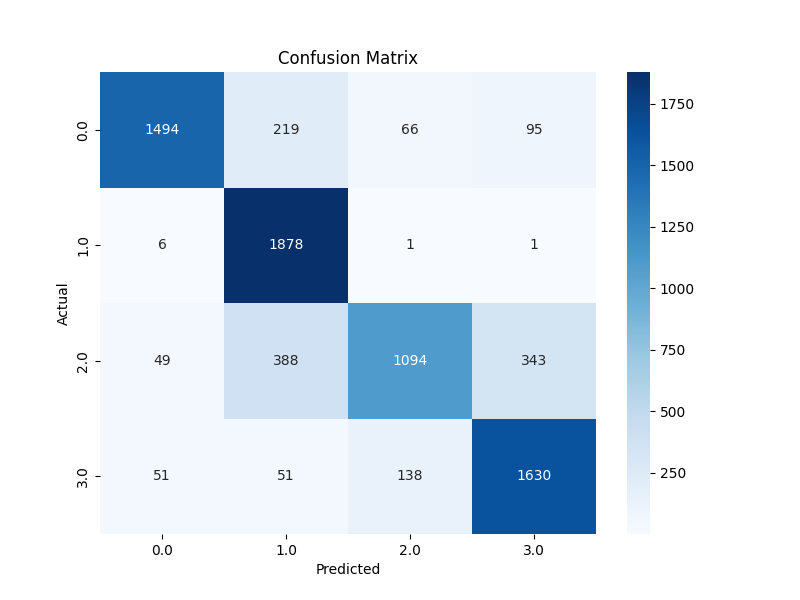

Above matrix is for all of the values that had been succuesfully called.

The code for other N-shot models is provided in separate notebooks for convenience.

# Deep learning architectures

We explored architectures such as:
 - Simple linear (1 hidden layer) Tokenizer Only
 - Simple Linear (1 hidden layer) + Embedding
 - LSTM + Embedding
 - BiLSTM + Embedding
 - CNN + Embedding

These architectures are more complex than Naive Bayes, but are relativly simple models when compared to the use of LLMs for zero shot classification.

For our test scenario we run the model for 15 epochs, and test the model after each epoch against the test set.

<br>

Legend for architectures explored in this section

![Legend](https://drive.google.com/thumbnail?&id=1a_COaQ7y4_zVswKK_o3zF_OvSdi3wHyK&sz=s4000)


## Summary:

Overall we find similar outcomes to the naive bayes and zero shot architectures. The majority of confusion exists between business and sci/tech.

As expected the LinearSimpleTokenizer was the least performant model (34% accuracy), with the LinearSimpleEmbedding model producing the best score of 91% accuracy over the 15 epochs.


## Performance
Most architectures reach 90% accuracy, with only the LinearSimpleEmbedding model reaching 91% for the test set.


![Confusion Matrix](https://drive.google.com/thumbnail?&id=1BegLKPomsLd1kr6X_hWSiXMj-SSCSjam&sz=s4000)

This figure depicts the test set accuracy over the 15 epochs of training. We note that the LSTM and BiLSTM take 3-4 epoch to warm up and start learning from sequential context and history.


![Test Accuracy](https://drive.google.com/thumbnail?&id=1aFdD1qIhI9ZLYoO1qHSKbkb2Th-T1tyY&sz=s500)






## Linear simple with just tokenizer


## Model Architecture
This is one of the simplest neural network baselines for text classification. It uses the following architecture:

Tokenizer:
The raw input text is tokenized using a simple method (e.g., word-level or subword-level tokenization). Each token is mapped to a unique integer index from a vocabulary.

Linear Layers:
Fully connected layers map the input vector to the number of output classes.

Softmax Output:
The softmax function converts raw scores to probabilities across classes (applied indirectly through the criterion).

In [ ]:
class LinearSimpleTokenzier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LinearSimpleTokenzier, self).__init__()

        h2= 256
        h3 = 100

        self.fc_1 = nn.Linear(input_dim, h2)
        self.layer_norm_2 = nn.LayerNorm(h2)

        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(h2, h3)
        self.layer_norm_3 = nn.LayerNorm(h3)


        self.fc_3 = nn.Linear(h3, output_dim)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.layer_norm_2(out)
        out = self.relu(out)
        out = self.fc_2(out)
        out = self.layer_norm_3(out)
        out = self.relu(out)
        out = self.fc_3(out)
        return out

In [ ]:
#epochs

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "LinearSimpleTokenzier",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = LinearSimpleTokenzier(100, 256, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.float32)
  test(testSet, model, train_column="original_input_ids", train_type=torch.float32)
  wandb.log({"train-loss": loss})
evaluate_model(testSet, model, train_type=torch.float32)

name= "SimpleLinearWithTokenizer"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)


run.finish()


## Simple linear with embedding

## Model Architecture
This extended architecture builds on the simple linear model by introducing an embedding layer that learns dense vector representations of words during training.

Tokenizer:
The raw input text is first tokenized, mapping each word or subword token to an integer index based on a vocabulary.

Embedding Layer:
Each token index is mapped to a trainable dense vector (embedding). These embeddings capture semantic relationships between words by placing similar words closer together in vector space.

Linear Layers:
The pooled embedding vector is passed through one or more fully connected layers that project it into the output class space.

Softmax Output:
The final output logits are converted into probabilities using a softmax function (applied indirectly through the criterion CrossEntropyLoss).

In [ ]:
class LinearSimpleEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LinearSimpleEmbedding, self).__init__()

        h2=100

        self.embedding = nn.Embedding(30000, input_dim)
        self.fc_1 = nn.Linear(input_dim, h2)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(h2, output_dim)

    def forward(self, x, hidden=None):
        out = self.embedding(x).mean(dim=1)
        out = self.fc_1(out)
        out = self.relu_1(out)
        out = self.fc_2(out)
        return out  # Returning hidden state for possible reuse

In [ ]:
#epochs
learning_rate = 0.0005
epochs = 15
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "LinearSimpleEmbedding",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = LinearSimpleEmbedding(100, 256, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.long)
  test(testSet, model, train_column="original_input_ids", train_type=torch.long)
  wandb.log({"train-loss": loss})
evaluate_model(testSet, model, train_type=torch.long)

name= "SimpleLinearWithEmbedding"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)


run.finish()

# CNN
## How Convolutions Are Adapted for 1D Text Classification
Convolutional Neural Networks (CNNs) are traditionally designed for 2D data like images, where the input is a grid of pixels. For text classification, the idea is similar but adapted to the 1D structure of language.

### Input Representation
Instead of a 2D pixel grid, the input is a sequence of word embeddings (dense vectors).
> Example: a sentence becomes a matrix of shape (sequence length × embedding dimension).

### 1D Convolutions
The convolutional filters slide only along the sequence dimension (not across embedding dimensions).
Each filter learns to detect local patterns across neighboring words, like key phrases, n-grams, or semantic patterns, in the sentence.

### Kernel Size
The kernel size specifies how many consecutive words the convolution looks at.
> For example, a kernel size of 3 acts like scanning trigrams (3-word windows) throughout the sentence.

### Multiple Filters
Different filters can specialise in detecting different kinds of word patterns, e.g., some might focus on financial terms, others on technology expressions, etc.

### Pooling
After convolutions, max-pooling is used to pick the strongest feature activations, helping the model become position-invariant, meaning it doesn't matter where in the sentence the important pattern appeared.

### Flatten + Fully Connected Layers
After pooling, the features are flattened and passed through dense layers to classify the text into categories.

> "In images, CNNs detect visual patterns like edges or shapes;
In text, CNNs detect semantic patterns like key phrases or word combinations."

# Architecture
This model extends traditional text classification approaches by using Convolutional Neural Networks (CNNs) to capture local n-gram patterns and hierarchical feature structures in the input text. The architecture is as follows:

### Tokenizer
Input text is first tokenized into integer indices, each representing a word from a predefined vocabulary.

### Embedding Layer
Each token is mapped to a dense, trainable embedding vector of fixed dimension (embed_dim). This allows the model to learn semantic representations of words during training.

### Convolutional Layers
The sequence of embeddings is permuted into a format suitable for 1D convolution: (batch size, channels, sequence length).

- Three stacked 1D convolutional layers progressively extract higher-level n-gram features:
  - First Conv1D Layer: 64 filters with a kernel size of 3 to detect local trigrams.
  - Second Conv1D Layer: 128 filters with a kernel size of 3 to extract more complex features.
  - Third Conv1D Layer: 256 filters with a kernel size of 3 to capture deep hierarchical patterns.
- After each convolution, a Leaky ReLU activation is applied to introduce non-linearity.

#### Pooling Layers

- A MaxPooling1D layer (with pool size 2) follows each convolutional layer to:
  - Downsample the feature maps.
  - Retain the most salient features.
  - Provide translation invariance over small shifts in word order.

#### Fully Connected Layers
After the final pooling, the output tensor is flattened.
- It is passed through two fully connected (dense) layers:
  - First FC Layer: Projects the flattened features into a hidden dimension (fc_hidden_dim) with Leaky ReLU activation and dropout for regularisation.
  - Second FC Layer: Maps to the number of output classes for classification.

#### Output Layer
The final output consists of raw logits (unnormalised scores), which are later passed to a loss function like CrossEntropyLoss, applying softmax internally to compute class probabilities.

### Key Strengths
CNNs efficiently capture local patterns (like phrases and key n-grams) regardless of their position.

Stacked convolutions and pooling create deep feature hierarchies without requiring sequence-level recurrence (unlike RNNs).

The architecture is fast, parallelisable, and suitable for large datasets like AG News.



![Text CNN Architecture](https://drive.google.com/thumbnail?&id=1pL0hwo4mW5vB4yWSxyFPw_uz8-zhzMxu&sz=s4000)



## Model Archtecture

In [ ]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_len, num_classes, dropout_rate=0.5, fc_hidden_dim=256):
        super(CNNModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Convolutional layers
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)

        # Max pooling layers
        self.pool = nn.MaxPool1d(2)

        # Calculate output size after convolutions + pooling
        def conv_out_size(input_size, kernel_sizes, pool_size):
            for k in kernel_sizes:
                input_size = input_size - (k - 1)
                input_size = input_size // pool_size
            return input_size

        conv_out_len = conv_out_size(max_len, [3, 3, 3], 2)
        fc_input_size = 256 * conv_out_len

        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_size, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Activation Function
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        # Embedding + Conv1D + Activation + BatchNorm + MaxPooling
        x = self.embedding(x).permute(0, 2, 1)  # permute to (batch, channels, seq_len)

        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [ ]:
#epochs

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "CNN",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = CNNModel(30000, 100, 100, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.long)
  test(testSet, model, train_column="original_input_ids", train_type=torch.long)
  wandb.log({"train-loss": loss})

evaluate_model(testSet, model, train_type=torch.long)

name= "CNN"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)


run.finish()


## LSTM

### Context for Using LSTMs in Text Classification
Text data has sequential structure. The meaning of a word often depends on the words that come before it.
Traditional methods (like CNNs or bag-of-words) don't capture long-term dependencies well.

Long Short-Term Memory networks (LSTMs) were specifically designed to handle sequential data.
They allow the model to remember important information across longer distances in the sequence, making them ideal for tasks like text classification where word order matters (e.g., "not good" vs "good").

Sequential understanding: Unlike CNNs (which focus on local patterns), LSTMs can model global sequence relationships.

Context preservation: LSTM cells decide what information to keep or discard through their gating mechanisms.

Suitability for text: Important for tasks where negations, context buildup, or long-range relationships impact meaning (e.g., distinguishing news articles in AG News).

In this project, the LSTM acts as a "reader" of the text, building an internal summary of the article, which it then classifies.

### Architecture

#### Input
- Tokenized text (batch of sequences)

#### Embedding Layer
- Each word index is mapped to a dense embedding vector.
- (vocab size = 30,000, embedding dim = input_dim)

#### LSTM Layer
- Processes the embedded sequences sequentially.
- Hidden size = hidden_dim (e.g., 128 or 256)
- Learns temporal relationships between tokens.
- Only the final hidden state (out[:, -1, :]) is used.

![LSTM Architecture](https://drive.google.com/thumbnail?&id=1_DVwvrpMYi0DWGEmvTFwLli6czvBQTp2&sz=s700)




The image above shows a deeper insight as to how the LSTM processes the input text.

#### Fully Connected Layer 1
- Linear layer projecting LSTM hidden output → 256 units (h2)
- Followed by ReLU activation (non-linearity)

#### Fully Connected Layer 2
- Linear layer projecting from 256 → number of classes (output_dim)

#### Output: Class logits
- Used to calculate cross-entropy loss during training.

This SimpleLSTM architecture allows the model to effectively capture sequential dependencies in the text, distill it into a fixed-size summary vector, and make a classification decision based on this learned representation.

In [ ]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(SimpleLSTM, self).__init__()

        h2=256
        h3=50
        self.embedding = nn.Embedding(30000, input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first =True)
        self.fc_1 = nn.Linear(hidden_dim, h2)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(h2, output_dim)

    def forward(self, x, hidden=None):

        # LSTM forward pass
        out = self.embedding(x)
        out, (h, c) = self.lstm(out)
        out = self.fc_1(out[:,-1,:])
        out = self.relu_1(out)
        # Take the last timestep output
        out = self.fc_2(out)
        return out  # Returning hidden state for possible reuse

In [ ]:
learning_rate = 0.0005
epochs = 15
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "SimpleLSTM",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = SimpleLSTM(100, 256, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_type=torch.long)
  test(testSet, model, train_type=torch.long)
  name= f"LSTM_{i}"
  path = f"./{name}.pth"
  torch.save(model.state_dict(), path)
  registered_model_name = name
  run.link_model(path=path, registered_model_name=registered_model_name)
  wandb.log({"train-loss": loss})
evaluate_model(testSet, model)

# name= "LSTM"
# path = f"./{name}.pth"
# torch.save(model.state_dict(), path)
# registered_model_name = name
# run.link_model(path=path, registered_model_name=registered_model_name)
run.finish()

## Bi-directional LSTM
> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0301835

### Context for Using Bi-directional LSTMs in Text Classification

Given that news headlines and article snippets often contain complex structures where both previous and future words influence the meaning, using a Bi-directional LSTM is a natural choice to also explore. Unlike standard LSTMs that only capture past context, BiLSTMs can simultaneously model information from both directions, enabling a deeper understanding of the full sentence structure.

In the context of AG News classification, where accurate categorisation can depend on subtle linguistic cues, BiLSTMs provide a richer, more informative representation of the text, leading to improved classification performance compared to unidirectional models.

A standard LSTM reads the text in one direction (usually left to right).
However, in many text tasks, both past and future context are important to understand a word or sentence fully.

Bi-directional LSTMs (BiLSTMs) solve this by training two LSTMs:

One processes the sequence forward (left → right)

One processes it backward (right → left)

Then, their outputs are concatenated.
This allows the model to have a full view of the surrounding context, which is crucial for more accurate classification.

In text classification, a BiLSTM can "understand" a word not just from what came before, but also from what comes after, which is very helpful when headlines or article snippets are short or ambiguous (like in AG News).

### Architecture

#### Input
- Tokenized text (batch of sequences)

#### Embedding Layer
- Maps word indices to dense vectors.
- (vocab size = 30,000, embedding dim = input_dim)

#### Bi-directional LSTM Layer
- Two LSTMs: one forward, one backward.
- Hidden size = hidden_dim for each direction.
- Output hidden states from both directions are concatenated.
- Final hidden size per timestep = hidden_dim * 2.


![LSTM Architecture](https://drive.google.com/thumbnail?&id=1SN79Uww0akiXgty1xIwNuzkp92epOfuO&sz=s700)

The image above gives a deeper look at how the Bi-LSTM network processes the inputs.

#### Fully Connected Layer 1
- Linear layer reducing the concatenated output (hidden_dim * 2) → 75 units (h2)
- ReLU activation introduces non-linearity.

#### Fully Connected Layer 2
- Linear layer mapping 75 → number of classes (output_dim).

#### Output: Class logits
- Used for computing the classification loss.

This BiLSTM architecture captures information from both preceding and succeeding words in the sequence, allowing the classifier to make more informed decisions based on full context around each token.

In [ ]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTM, self).__init__()

        h2=75
        h3=50
        self.embedding = nn.Embedding(30000, input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim,num_layers=1, batch_first =True, bidirectional=True)
        self.fc_1 = nn.Linear(hidden_dim*2, h2)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(h2, output_dim)

    def forward(self, x, hidden=None):

        # LSTM forward pass
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = self.fc_1(out[:, -1, :])
        out = self.relu_1(out)
        # Take the last timestep output
        out = self.fc_2(out)
        return out  # Returning hidden state for possible reuse

In [ ]:

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "BiLSTM",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = BiLSTM(100, 256, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_type=torch.long)
  test(testSet, model, train_type=torch.long)
  wandb.log({"train-loss": loss})
evaluate_model(testSet, model)

name= "BiLSTM"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)

run.finish()

# Alternative architecture

We present a new set of architectures to tackle news classification.

Prior architectures (LSTM, CNN, SimpleLinear and BiLSTM) aim to embed semantic meaning and extract meaning out of sequential information from the text on hand to classify text.

<br>

## Hypothesis 1: It's a sequence problem
We spectualte that the original deep learning architectures we explored lack mechanisms to effectively extract meaning from the sequence of text. To explore this hypothesis we use two models.

- **Simple attention model**: We use an self-attention head mechanism with 16 heads.
- **Fine tune version of Bert**: We use bert-uncased-transformer architecture with a classifcation head.

These models are effective at attenting to, and extracting information from text patterns.

<br>

## Hypothesis 2: It's a semantic issue

On the other hand, there is an argument that semantic meaning is lacking. If we consider that LSTM and BiLSTM produce very similar results, we can infer that contextual information (the sequence to sequence information) is being effectively extracted and providing all the information it can.

If this is the case, we speculate that improving semantic meaning via improved embedding produced from outside source may improve performance. To test this hypothesis we explore the use of GLoVe models to embed text into the best LSTM and Linear models. We chose a GLoVe emebedding model because of it's simplicity, which will quickly confirm or reject our hypotheisis.


## Hypothesis #1
We test two models,
- A BERT pretrained with sequence to sequence classificaiton head.
- A simple attention head linear architecture


| Model                 | Training Time | Parameters   | Accuracy |
|-----------------------|---------------|--------------|----------|
| Self Attention Simple | 3m            | 7,779,716    | 89%      |
| BERT                  | 7m            | 109,485,316  | 90%      |



Legend

![Legend](https://drive.google.com/thumbnail?&id=1l32Tz0FdLDDECauxFf07unaHs9Nw7plt&sz=s700)


Confusion Matrix


![Confusion Matrix](https://drive.google.com/thumbnail?&id=1NlL4vkKwbBmOcEz2El_hrKII_x_2u8JZ&sz=s700)

The further code below showcases how we got to this point.



### Linear simple with attention

In modern NLP tasks, attention mechanisms have become crucial because they allow models to focus on the most relevant parts of the input sequence, rather than treating all words equally.

In our AG News classification problem, certain keywords or phrases (like "stocks", "government", "software") are often much more important than others in determining the article's category.
Initially, our simpler models (such as basic linear and LSTM architectures) achieved strong performance but began to hit an accuracy ceiling.

To try and push beyond this plateau, we explored incorporating attention, allowing the model to selectively emphasise important tokens and potentially boost overall accuracy, without immediately resorting to heavier transformer models.

This model strikes a balance between efficiency and performance, offering a lightweight alternative to heavier models like full LSTMs or Transformers.

### Architecture
#### Input
Raw text tokens (integers)

#### Embedding Layer
Maps each token into a dense vector (dimension = 256)

#### Positional Encoding
Adds learned position information to embeddings (since attention itself is permutation-invariant)

#### Multihead Attention
16 attention heads applied on the sequence.

#### Self-attention
The model learns to attend to different parts of the sentence.

#### Layer Normalisation
Stabilises and speeds up training by normalising the attention outputs.

#### Fully Connected Layer 1
Reduces the output from the attention block to a smaller hidden size (128 units).

#### Activation
ReLU

#### Fully Connected Layer 2
Maps hidden size to the number of output classes (4 for AG News categories).

#### Output
Raw logits for each class (to be fed into a softmax during evaluation).

Input Text --> Embedding Layer --> + Positional Encoding -->
    Multihead Attention --> LayerNorm -->
        FC Layer (256 -> 128) --> ReLU -->
            FC Layer (128 -> 4) --> Output


In [ ]:


class LinearSimpleEmbeddingAttention(nn.Module):
    def __init__(self, input_dim, embed_dim=256, hidden_dim=200, output_dim=4, num_layers=1):
        super(LinearSimpleEmbeddingAttention, self).__init__()

        h2=128
        self.embedding = nn.Embedding(30000, embed_dim) ##[Batch, seq_length, embedding]
        self.positional_encoding = nn.Parameter(torch.randn(100, 256)) ##[Batch, seq_length, embedding]

        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=16, dropout=0.2) ##[Batch, seq_length, embedding]
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_1 = nn.Linear(embed_dim, h2)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(h2, output_dim)

    def forward(self, x, hidden=None):
        out = self.embedding(x)
        out += self.positional_encoding

        attention_weights, _ = self.attention(out, out, out)
        attention_weights = attention_weights.mean(dim=1)
        norm = self.layer_norm(attention_weights)
        # out, _ = self.lstm(out)
        out = self.fc_1(norm)
        out = self.relu_1(out)
        # Take the last timestep output
        out = self.fc_2(out)
        return out  # Returning hidden state for possible reuse

In [ ]:
learning_rate = 0.0005
epoch = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "SimpleLinearSelfAttention",
        "dataset": "AGNewsSet",
        "epochs": epoch,
    },
)

model = LinearSimpleEmbeddingAttention(512, 256, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epoch):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_type=torch.long)
  test(testSet, model, train_type=torch.long)
  wandb.log({"train-loss": loss})
evaluate_model(testSet, model)


name= "SimpleLinearWithAttention"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)



run.finish()

In [ ]:
import os
os.listdir('/content/')
import pandas as pd

file_path = "/content/test.csv"  # Make sure this matches your filename
df = pd.read_csv(file_path)

# Display first few rows
df.head()
df.columns
df.shape
df["Class Index"].unique()
df[df["Class Index"] == 1]
df[df["Class Index"] == 2]

#Find the Most Frequent Words in Titles:

from collections import Counter

word_counts = Counter(" ".join(df["Title"]).split())
most_common_words = word_counts.most_common(10)  # Top 10 words
print(most_common_words)

#Find the Longest News Article (by description length)
df.loc[df["Description"].str.len().idxmax()]

#Find the Shortest News Article
df.loc[df["Description"].str.len().idxmin()]

category_counts = df["Class Index"].value_counts()
print(category_counts)

# Calculate the percentage of each category
category_percentage = df["Class Index"].value_counts(normalize=True) * 100

# Convert to DataFrame for better visualization
category_distribution = pd.DataFrame({
    "Class Index": category_percentage.index,
    "Percentage": category_percentage.values
})

print(category_distribution)

# Bar chart for better readability
plt.figure(figsize=(10, 5))
category_percentage.plot(kind="bar", color="skyblue")
plt.title("Category-wise Percentage Distribution")
plt.xlabel("Class Index (News Category)")
plt.ylabel("Percentage of Dataset")
plt.xticks(rotation=0)
plt.show()


### Bert Model

As part of our Alternative Architecture exploration, we present fine-tuning BERT (Bidirectional Encoder Representations from Transformers) as a model under Hypothesis 1: It's a sequence problem.

Prior models like LSTM, CNN, Simple Linear, and BiLSTM aimed to embed semantic meaning from text, but we hypothesised that these architectures might not fully extract meaning from sequential patterns in text.

To address this, we explored architectures specifically designed to attend to and extract deeper information from text sequences.

BERT, developed by Devlin et al. (2018), introduces self-attention mechanisms that allow the model to process and relate all parts of a sentence simultaneously, capturing rich, bidirectional context.
Instead of learning from scratch, we fine-tune a pre-trained bert-base-uncased model with a classification head tailored for AG News classification.

By using BERT, we leverage its pre-learned deep understanding of language (from massive corpora like Wikipedia) to potentially break through the accuracy ceiling we observed with earlier models, and more effectively capture intricate patterns in news text.

### Architecture

![BERT Architecture](https://drive.google.com/thumbnail?&id=1BKirF-Vi_dLmMvukMc31kwDd6SswR2J3&sz=s700)

The BERT architecture begins by converting each input token into a word embedding, which is combined with positional embeddings to incorporate the order of words in the sequence. These combined embeddings are fed into a series of transformer layers, where each layer is made up of a Multi-Head Attention mechanism followed by a Feed Forward Network. Residual connections and layer normalisation are applied after each sub-layer to stabilise training and help information flow more easily through the network.

This core block is stacked 12 times in the base BERT model. After passing through all transformer layers, the final hidden state (usually of the special [CLS] token) is fed into a Linear layer followed by a Softmax to produce output probabilities for classification tasks. This architecture allows BERT to capture rich relationships between words across an entire sequence, making it especially powerful for tasks like text classification.



#### Refactored code

In [ ]:
import torch
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer, AutoModelForSequenceClassification
learning_rate = 0.0005
epoch = 20

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "BERT",
        "dataset": "AGNewsSet",
        "epochs": epoch,
    },
)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_integer_map)
)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epoch):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_type=torch.long)
  test(testSet, model, train_type=torch.long)
  wandb.log({"train-loss": loss})

evaluate_model(testSet, model)
run.finish()

In [ ]:
import pandas as pd
bert_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/9444/Results_Data/bert_predictions_final.csv')

collect_label = bert_df['label']
collect_pred = bert_df['Predicted Label']

correct = sum(collect_label == collect_pred)

run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    id="kgzuzzrx",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.0005,
        "architecture": "Bert",
        "dataset": "AGNewsSet",
        "epochs": 15,
    },
)

# Confusion Matrix
wandb.log({"conf_id" :wandb.plot.confusion_matrix(
            preds=collect_pred, y_true=collect_label, class_names=list(label_map_arr))})


  #Accuracy:
accuracy =  100*correct/len(collect_label)
print(f"Eval accuracy: {accuracy}%")
wandb.log({"eval-accuracy":accuracy})

#recall
recall = recall_score(collect_label, collect_pred, labels=label_integer_map, average='weighted')
print(f"Eval recall: {recall}")
wandb.log({"eval-recall":recall})

# Precision:
precision = precision_score(collect_label, collect_pred,labels=label_integer_map, average='weighted')
print(f"Eval precision: {precision}")
wandb.log({"eval-precision":precision})

# F1 Score
f1_score_ = f1_score(collect_label, collect_pred,labels=label_integer_map, average='weighted')
print(f"Eval f1_score: {f1_score_}")
wandb.log({"eval-f1_score":f1_score_})



run.finish()

## Hypothesis #2
After evaluating BERT and noting that it did not significantly improve classification accuracy as much as we had hoped, we considered a second hypothesis.

There is a strong argument that the core limitation lies not in sequence modeling, but in the semantic richness of the input embeddings. If models like LSTM and BiLSTM achieve similar results, it suggests that sequential information is already being effectively extracted. Therefore, the issue may not be "how" we are modeling the sequence, but rather "what" information the embeddings contain.

To explore this idea, we test whether improving the semantic quality of embeddings could boost model performance. Specifically, we introduce GloVe embeddings into our best-performing LSTM and Linear models. GloVe embeddings are trained on large corpora to capture broader word relationships and meanings, and they offer a simple yet effective way to evaluate whether enhanced semantic information leads to better classification outcomes.


![BERT Architecture](https://drive.google.com/thumbnail?&id=191UTP4tIiRwEUSd4ND0CZ6xzgLNvUScH&sz=s700)

The image above showcases how vectors in GloVe embeddings can be used to determine the relationship between words.

We test four scenarios over two models and two embedding dimensions
- LSTM and Linear
- 100d and 200d Glove embeddings

Results

| Model           | Dimension | Training Time | Parameters | Accuracy |
|----------------|-----------|----------------|------------|----------|
| LSTM + GloVe    | 100d      | 2m             | 3,170,576  | 92.10%   |
|                 | 200d      | 2m             | 6,274,076  | 92.10%   |
| Linear + GloVe  | 100d      | 3m             | 3,052,300  | 91.80%   |
|                 | 200d      | 3m             | 6,125,104  | 91.90%   |


Legend


![Legend](https://drive.google.com/thumbnail?&id=1HTnftq1jXFc9W968drwskzcCCFiSHR_q&sz=s700)


Confusion Matrix


![Confusion Matrix](https://drive.google.com/thumbnail?&id=1JGleU0FGBhFFMYolKzSoNI9LXJ8bSi5C&sz=s700)



Accuracy over 15 epochs

![Accuracy](https://drive.google.com/thumbnail?&id=1wLeqOfgIHkr8rt8UdBhHMtu3u28LLFf4&sz=s700)



### LSTM with Glove

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

batch_size = 100
output_dim = 4

train_loader, val_loader = torch.utils.data.random_split(trainSet.dataset, [0.8, 0.2])
# Create DataLoaders for each subset
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)


# Path to your local GloVe file
glove_path = f'{folder}/glove.6B (small)/glove.6B.100d.txt'

# Load GloVe vectors into a dictionary
embedding_dim = 100
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


word_index = tokenizer.vocab
vocab_size = len(word_index) + 1  # +1 for padding index
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Convert to tensor
weights_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(weights_matrix, freeze=False)

In [ ]:

class GloveLSTM(nn.Module):
    def __init__(self, embedding_layer, num_hid, num_classes, dropout_rate=0.5, num_layers=1):
        super(GloveLSTM, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(input_size=embedding_layer.embedding_dim,
                            hidden_size=num_hid,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(num_hid, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:,-1,:])        # [batch_size, sequence, output_dim]

        return out


In [ ]:
#epochs

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "LSTMWithGlove",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = GloveLSTM(embedding_layer, 128, 4, dropout_rate=0.5, num_layers=1).to(device)
# model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.long)
  test(testSet, model, train_column="original_input_ids", train_type=torch.long)
  wandb.log({"train-loss": loss})

evaluate_model(testSet, model, train_type=torch.long)

name= "LSTMWithGlove"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)


run.finish()


### Linear with Glove

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

batch_size = 100
output_dim = 4

train_loader, val_loader = torch.utils.data.random_split(trainSet.dataset, [0.8, 0.2])
# Create DataLoaders for each subset
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)


# Path to your local GloVe file
glove_path = f'{folder}/glove.6B (small)/glove.6B.100d.txt'

# Load GloVe vectors into a dictionary
embedding_dim = 100
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


word_index = tokenizer.vocab
vocab_size = len(word_index) + 1  # +1 for padding index
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Convert to tensor
weights_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(weights_matrix, freeze=False)

In [ ]:
class GloveLinear(nn.Module):
    def __init__(self, embedding_layer, input_dim, output_dim, num_layers=1):
        super(GloveLinear, self).__init__()

        h2=100

        self.embedding = embedding_layer
        self.fc_1 = nn.Linear(input_dim, h2)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(h2, output_dim)

    def forward(self, x, hidden=None):

        # LSTM forward pass
        out = self.embedding(x).mean(dim=1)
        # out, _ = self.lstm(out)
        out = self.fc_1(out)
        out = self.relu_1(out)
        # Take the last timestep output
        out = self.fc_2(out)
        return out  # Returning hidden state for possible reuse

In [ ]:
#epochs

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "LinearWithGlove",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = GloveLinear(embedding_layer, 100, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.long)
  test(testSet, model, train_column="original_input_ids", train_type=torch.long)
  wandb.log({"train-loss": loss})

evaluate_model(testSet, model, train_type=torch.long)

name= "LinearWithGlove"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)


run.finish()


### LSTM with Glove 200d

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

batch_size = 100
output_dim = 4

train_loader, val_loader = torch.utils.data.random_split(trainSet.dataset, [0.8, 0.2])
# Create DataLoaders for each subset
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)


# Path to your local GloVe file
glove_path = f'{folder}/glove.6B (small)/glove.6B.200d.txt'

# Load GloVe vectors into a dictionary
embedding_dim = 200
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


word_index = tokenizer.vocab
vocab_size = len(word_index) + 1  # +1 for padding index
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Convert to tensor
weights_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(weights_matrix, freeze=False)

In [ ]:

class GloveLSTM(nn.Module):
    def __init__(self, embedding_layer, num_hid, num_classes, dropout_rate=0.5, num_layers=1):
        super(GloveLSTM, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(input_size=embedding_layer.embedding_dim,
                            hidden_size=num_hid,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(num_hid, num_classes)

    def forward(self, x):
        x = self.embedding(x)

        output, (hn, cn) = self.lstm(x)

        out = self.fc(output[:,-1 , :])

        return out


In [ ]:
#epochs

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "LSTMWithGlove_200d",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = GloveLSTM(embedding_layer, 128, 4, dropout_rate=0.5, num_layers=1)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.long)
  test(testSet, model, train_column="original_input_ids", train_type=torch.long)

  wandb.log({"train-loss": loss})
  name= f"LSTMWithGlove_200d_{i}"
  path = f"./{name}.pth"
  torch.save(model.state_dict(), path)
  registered_model_name = name
  run.link_model(path=path, registered_model_name=registered_model_name)

evaluate_model(testSet, model, train_type=torch.long)
run.finish()


### Linear with Glove 200d

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

batch_size = 100
output_dim = 4

train_loader, val_loader = torch.utils.data.random_split(trainSet.dataset, [0.8, 0.2])
# Create DataLoaders for each subset
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)


# Path to your local GloVe file
glove_path = f'{folder}/glove.6B (small)/glove.6B.200d.txt'

# Load GloVe vectors into a dictionary
embedding_dim = 200
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


word_index = tokenizer.vocab
vocab_size = len(word_index) + 1  # +1 for padding index
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Convert to tensor
weights_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(weights_matrix, freeze=False)

In [ ]:
class GloveLinear(nn.Module):
    def __init__(self, embedding_layer, input_dim, output_dim, num_layers=1):
        super(GloveLinear, self).__init__()

        h2=100

        self.embedding = embedding_layer
        self.fc_1 = nn.Linear(input_dim, h2)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(h2, output_dim)

    def forward(self, x, hidden=None):

        # LSTM forward pass
        out = self.embedding(x).mean(dim=1)
        # out, _ = self.lstm(out)
        out = self.fc_1(out)
        out = self.relu_1(out)
        # Take the last timestep output
        out = self.fc_2(out)
        return out  # Returning hidden state for possible reuse

In [ ]:
#epochs

learning_rate = 0.0005
epochs = 15

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "LinearWithGlove_200",
        "dataset": "AGNewsSet",
        "epochs": epochs,
    },
)

model = GloveLinear(embedding_layer, 200, 4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
  print(f'epoch:{i}')
  model, loss = train(trainSet, model, train_column="original_input_ids", train_type=torch.long)
  test(testSet, model, train_column="original_input_ids", train_type=torch.long)
  wandb.log({"train-loss": loss})

evaluate_model(testSet, model, train_type=torch.long)

name= "LinearWithGlove_200"
path = f"./{name}.pth"
torch.save(model.state_dict(), path)
registered_model_name = name
run.link_model(path=path, registered_model_name=registered_model_name)


run.finish()


## Final Glove with LSTM Optimised Grid Search

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

batch_size = 100
output_dim = 4

train_loader, val_loader = torch.utils.data.random_split(trainSet.dataset, [0.8, 0.2])
# Create DataLoaders for each subset
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)


# Path to your local GloVe file
glove_path = f'{folder}/glove.6B (small)/glove.6B.200d.txt'

# Load GloVe vectors into a dictionary
embedding_dim = 200
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


word_index = tokenizer.vocab
vocab_size = len(word_index) + 1  # +1 for padding index
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Convert to tensor
weights_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(weights_matrix, freeze=False)

In [ ]:
class GloveLSTM(nn.Module):
    def __init__(self, embedding_layer, num_hid, num_classes, dropout_rate=0.5, num_layers=1):
        super(GloveLSTM, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(input_size=embedding_layer.embedding_dim,
                            hidden_size=num_hid,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(num_hid, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:,-1,:]) ## Made a change here
        return out


In [ ]:

def train_and_validate_glove_lstm(embedding_layer, num_hid, num_classes, dropout_rate, num_layers, lr, num_epochs=5, patience=3, train_loader=train_loader, val_loader=val_loader):
    print(f"\nTraining GloveLSTM with GloVe, num_hid={num_hid}, dropout={dropout_rate}, lr={lr:.0e}")

    model = GloveLSTM(
        embedding_layer=embedding_layer,
        num_hid=num_hid,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        num_layers=num_layers
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_accuracy = 0.0
    best_state_dict = None

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0

        for batch_idx, data in enumerate(train_loader):
            data, target = data['input_ids'].to(torch.long).to(device), data['label_list'].to(torch.float32).to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                      f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for batch_idx, data in enumerate(val_loader):
                data, target = data['input_ids'].to(torch.long).to(device), data['label_list'].to(torch.float32).to(device)
                y_pred = model(data)
                val_loss += criterion(y_pred, target).item()
                pred = y_pred.argmax(dim=1, keepdim=True)
                test_label_formatted =  target.argmax(dim=1, keepdim=True)
                correct += pred.eq(test_label_formatted).sum().item()

        val_loss /= len(val_loader)
        accuracy = 100. * correct / len(val_loader.dataset)

        print(f'Validation Epoch {epoch}: Avg loss = {val_loss:.4f}, Accuracy = {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)\n')

        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_state_dict = model.state_dict()

        # Early Stopping Logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    return best_accuracy, best_state_dict, train_losses, val_losses, val_accuracies


In [ ]:
num_hids = [128, 192, 256]
dropouts = [0.3, 0.5]
num_layers_list = [1, 2]
lrs = [5e-4, 3e-4]

results = []
best_accuracy = 0
best_model_state = None
best_hyperparams = None

best_model_training_losses = None
best_model_val_losses = None
best_model_val_acc = None

In [ ]:
num_epochs = 10

# Grid search loop
for num_hid in num_hids:
    for dropout in dropouts:
        for num_layers in num_layers_list:
            for lr in lrs:
                acc, model_state, train_losses, val_losses, val_accuracies = train_and_validate_glove_lstm(
                    embedding_layer=embedding_layer,
                    num_hid=num_hid,
                    num_classes=4,
                    dropout_rate=dropout,
                    num_layers=num_layers,
                    lr=lr,
                    num_epochs=num_epochs,
                    patience=3
                )
                results.append((num_hid, dropout, num_layers, lr, acc))

                if acc > best_accuracy:
                    best_accuracy = acc
                    best_model_state = model_state
                    best_hyperparams = {
                        'num_hid': num_hid,
                        'dropout': dropout,
                        'num_layers': num_layers,
                        'lr': lr
                    }

                    best_model_training_losses = train_losses
                    best_model_val_losses = val_losses
                    best_model_val_acc = val_accuracies

                print(f"hidden_dim={num_hid}, dropout={dropout}, num_layers={num_layers}, lr={lr:.0e} --> val_acc={acc:.4f}")

# Results
We find that the LSTM model enhanced with GloVe embeddings provides the best overall performance, while maintaining comparable efficiency to other approaches.

Our initial hypothesis, that sequential context was not being fully captured by standard LSTM models, was rejected. LSTM and BiLSTM architectures were already extracting as much sequence-level information as possible, and adding more complex sequence modeling (such as attention mechanisms or transformers) did not result in substantial performance gains.

On the other hand, our second hypothesis, that semantic richness was lacking in our initial embeddings, was supported. By introducing GloVe embeddings, which better encode semantic relationships between words, we achieved a noticeable improvement in classification accuracy. This suggests that for the AG News dataset, enhancing the quality of the input representations is more beneficial than adding complexity to the model architecture itself.

<br>

Examining Hypothesis 1, Attention mechanism, we note:

Model | Parameters | Accuracy
--- | --- | ---
Linear | 3,010,504 | 90.4%
Self Attention Simple | 7,779,716 | 89.1% |
Bert | 109,485,316 | 90.1%

<br>


Examining Hypothesis 2, Semantic improvement, we note:

Model | Parameters | Accuracy
--- | --- | ---
LSTM | 3,433,412 | 89.9%
LSTM with Glove | 3,170,576 | 92.1%
LSTM with Glove 200 | 6,274,076 | 92.1%
--- | --- | ---
Linear | 3,010,504 | 91.6%
Linear with Glove | 3,052,300 | 91.8%
Linear with Glove 200 | 6,125,104 | 91.9%



# Discussion
Our initial hypothesis was that the full sequential structure and deeper text patterns within the articles were not being adequately captured by simpler models like LSTM and SimpleLinear. We speculated that more advanced architectures designed to extract complex dependencies (such as self-attention mechanisms [Simple Attention model] and transformer-based architectures [BERT]) would lead to significant improvements in classification accuracy.

However, our experiments demonstrate that this hypothesis is incorrect. Both the Simple Attention model and fine-tuned BERT produced similar or even slightly worse accuracies compared to the baseline LSTM and SimpleLinear models. Despite their theoretical ability to model richer dependencies and attend across the input sequence more flexibly, these models did not substantially outperform the simpler approaches on the AG News classification task.

This suggests that for this particular dataset, sequential dependencies and long-range contextual relationships are not the primary bottleneck. Instead, the models were already capturing most of the useful sequence information, and additional architectural complexity did not translate into better performance.

## Strengths
Our approach demonstrates that leveraging richer embeddings (particularly those trained on diverse, external datasets) can significantly enhance classification accuracy without the need to increase the model's parameters substantially. This is a key strength of our method, as it allows for improved performance with minimal computational overhead.

1. Improved Accuracy with Richer Embeddings: By incorporating embeddings such as the 100d and 200d GloVe representations, we are able to capture richer semantic meanings of words, which ultimately helps the model differentiate between subtle but important distinctions in context. The embeddings trained on larger, more diverse datasets help capture word relationships and associations that go beyond mere word co-occurrence, allowing our model to better understand the nuances of language. This improvement in semantic representation helps the model better understand the meaning of phrases and topics, leading to more accurate classifications.

2. Enhancing Overlap and Contextual Clarity: One of the primary benefits of using GloVe embeddings in our model is their ability to improve classification accuracy for articles that involve overlapping topics or ambiguous terms. In traditional models, words with multiple meanings or words that appear frequently in different contexts might confuse the classifier. However, by utilising embeddings that encode more detailed semantic relationships, we are able to better disambiguate terms based on context. This is particularly important in news article classification, where the same word can often be used across different topics, yet carry distinct meanings.

  For example, consider the case of a simple LSTM model versus a GloVe-enhanced LSTM model. The sentence:

  > "Panasonic, Toshiba delve into alternate energy. A new home heating system from Panasonic is based on a hydrogen fuel cell; it both heats the house and produces hot water."

  In this case, the simple LSTM model classifies the article as "Business," based on common associations of words like "energy" and "fuel" with business contexts. However, the GloVe-enhanced LSTM model classifies this same article as "Technology." This distinction arises because the richer GloVe embeddings incorporate domain-specific knowledge and context, which help the model understand that terms like "hydrogen," "fuel," and "cell" (especially when associated with a company like Panasonic) are more likely to pertain to technological advancements rather than traditional business topics.

3. Contextual Influence of Scientific and Technological Terms: The success of this classification demonstrates the power of embedding models in capturing the interplay between domain-specific and general knowledge. While words like "fuel" and "energy" might generally lead to a business classification due to their frequent association with economic and commercial discussions, the specific use of "hydrogen" and "fuel cell" in this case shifts the context toward technology. The enhanced embeddings, which incorporate a richer set of contextual relationships, enable the model to identify this subtle but crucial distinction. This demonstrates how embeddings can provide valuable contextual insights, guiding the model to make more accurate, domain-specific classifications.

4. Efficiency in Model Parameters: An essential strength of our approach is that we are able to achieve these accuracy improvements without significantly increasing the number of parameters in the model. By applying pre-trained GloVe embeddings, which are already optimised to capture word semantics across a large corpus, we bypass the need to retrain the word representations from scratch. This allows us to maintain a relatively lightweight model while still benefiting from the semantic richness of the embeddings. In contrast, more complex models that aim to improve accuracy through increased parameters (such as large-scale transformers) often come with higher computational costs. Our approach strikes a balance between performance and efficiency, making it a practical solution for many real-world applications.

5. Consistency of Training Parameters: Furthermore, by integrating these rich embeddings into our model, we ensure that the number of parameters required to train the classifier remains consistent. This provides a clear advantage over other approaches that necessitate the adjustment of hyperparameters or the introduction of complex layers to improve model performance. The simplicity of our approach allows us to focus on optimising the embeddings rather than overhauling the underlying architecture. This results in a more stable and interpretable training process, which is crucial for both research and industrial applications.

## Weaknesses
Our method requires emebeddings derived from out of text articles. Our method to use embedding with richer semantic meanings requires the text used to create a richer emebedding to be sourced from a richer and potentially more diverse dataset. We note that there was limited improvement when comparing a model using 100d and 200d Glove embeddings. This suggests that either we have reached the limit of Glove embeddings, or require a larger embedding model that captures richer semantics to provide any improvement.

Our method relies heavily on embeddings derived from out-of-context articles. While embeddings are a powerful tool for transforming text into a dense vector space, the effectiveness of these embeddings can be limited by the quality and diversity of the underlying dataset used for training. Specifically, we use pre-trained embeddings like GloVe, which capture statistical relationships between words based on co-occurrence patterns within a corpus. However, this dependency introduces several limitations to the robustness and performance of our models.

1. Dependence on Textual Embedding Sources: The embeddings used in our approach are derived from a static dataset, which may not fully capture the nuances or domain-specific knowledge required for tasks such as classifying news articles. For embeddings to carry richer semantic meanings, the source texts from which they are derived need to be highly diverse and representative of the variety of content found in the target task. Since our method depends on embeddings that were trained on a general corpus, it is possible that these embeddings lack the specificity required to effectively represent more complex or domain-specific language. As such, the model might not perform as well when dealing with specialised vocabulary or intricate contextual relationships in the news articles.

2. Limited Improvement from Embedding Size: We tested our model with both 100-dimensional (100d) and 200-dimensional (200d) GloVe embeddings to assess the impact of embedding size on performance. Surprisingly, the improvement in classification accuracy was minimal between the two configurations. This result suggests two possibilities:

  - Saturation of GloVe Embeddings: The relatively modest increase in performance could indicate that the GloVe embeddings, particularly at these dimensions, have reached a saturation point. That is, they may already encode a sufficient level of semantic information for the task at hand, and increasing their dimensionality beyond a certain point does not yield substantial improvements. This phenomenon might also suggest that the embeddings' representation capacity is constrained by the quality of the underlying corpus they were trained on, limiting their ability to capture additional or more meaningful distinctions between words.

   - Need for Larger, More Sophisticated Embeddings: Alternatively, this could point to a need for embeddings that better capture more complex and nuanced meanings. Embedding models such as FastText, ELMo, or BERT (particularly those trained on larger, more diverse, and task-specific datasets) could offer a richer semantic space for representing words in context. These newer embeddings are context-aware and can capture fine-grained differences in meaning depending on word usage, making them better suited for complex tasks like news article classification.

3. Lack of Contextual Understanding: Another drawback is that traditional embeddings like GloVe are static (they represent words as fixed vectors, without accounting for the context in which the word appears). In news articles, context plays a crucial role in determining meaning. For example, the word “bank” could refer to a financial institution or the side of a river depending on the surrounding text. Static embeddings do not capture this dynamic aspect, and as such, may fail to represent such ambiguities effectively.

4. Potential Overfitting to General Corpus: Embeddings like GloVe are trained on massive general corpora, such as Wikipedia or Common Crawl. While these corpora contain a wealth of information, they may not always reflect the specific tone, style, or terminology used in news articles. As a result, the embeddings might carry irrelevant or noisy features that do not contribute to the classification task. This misalignment can lead to overfitting on patterns that are more characteristic of general language use rather than the specific language found in news contexts.

## Limitations
While our work demonstrates that the use of richer embeddings can efficiently improve accuracy in the news classification task, there are several limitations to our study, mainly due to constraints in time and resources. These limitations prevent us from fully exploring the potential benefits of more advanced, attention-based models, such as BERT, which could further enhance classification performance.

1. Limited Exploration of Attention-Based Models: Although our method utilising GloVe embeddings significantly boosted accuracy, we acknowledge that attention-based models, such as BERT (Bidirectional Encoder Representations from Transformers), represent a promising direction for future research. These models are designed to capture intricate dependencies within the input text by attending to different parts of a sentence, regardless of their position. This ability to focus on relevant sections of the text could result in even more accurate classifications, especially in cases where context plays a crucial role in determining meaning. Unfortunately, our study did not have the time or resources to fully integrate BERT or similar transformer models into our classification pipeline. Given the current state-of-the-art performance of these models across various NLP tasks, we speculate that they could provide substantial improvements in news classification, particularly for articles with complex or multi-faceted topics.

2. Computational Constraints: A key limitation in exploring more sophisticated models like BERT is the significant computational resources required for training and fine-tuning such models. BERT, for instance, involves millions of parameters and requires considerable GPU or TPU resources to run efficiently. Due to the high cost of these resources and the time constraints of our study, we were unable to fully explore how these models could impact the accuracy of our classification system. While pre-trained versions of BERT (such as distilBERT or smaller transformer models) could be used to reduce resource demands, the trade-off between model size and performance remains a challenge in terms of computational efficiency.

3. Focus on GloVe Embeddings Rather Than Transformer Models: Our study predominantly focused on the use of static word embeddings, like GloVe, which represent words as fixed vectors regardless of their context. While GloVe embeddings proved effective in improving accuracy, they are inherently limited compared to transformer-based models, which offer dynamic, context-aware representations of words. A more in-depth exploration of models like BERT, which captures contextual relationships on a deeper level, could have led to even better results in cases where subtle shifts in word meaning are essential for correct classification. However, given our focus on the efficiency of embedding-based models and the need for a practical solution within the scope of our project, this avenue was not fully explored.

4. Limited Dataset and Task Scope: Another limitation is the focus on the AG News dataset, which, while a commonly used benchmark, may not fully represent the complexities of real-world news content. A richer exploration of other datasets or multi-domain news sources could have provided additional insights into how transformer-based models like BERT might perform across different types of news articles. Moreover, our work was centered around a classification task, whereas BERT and similar models excel in a range of NLP tasks beyond classification, such as named entity recognition or question answering. Future work could broaden the scope to include such tasks, providing a more holistic view of the model's capabilities and limitations.

## Future Work
Our study has laid the groundwork for future exploration in several promising areas:

1. Fine-Tuning Transformer Models (e.g., BERT) and Domain-Specific Variants: Although our work focused on static embeddings like GloVe, transformer models such as BERT have revolutionised the field of NLP by providing context-aware representations of text. Future work could involve fine-tuning these pre-trained transformers for the specific domain of news articles, which may yield even better performance. Additionally, exploring domain-specific variants of transformer models (such as NewsBERT, which could be fine-tuned specifically on news articles) could lead to significant improvements. These models would be able to capture more nuanced relationships and domain-specific vocabulary, further enhancing classification accuracy.

2. Multimodal Data Integration: Another exciting avenue for future research is experimenting with multimodal data, which could include images, metadata, and social signals. The AG News dataset, for instance, contains URLs pointing to images that accompany the articles. These images, along with other types of metadata such as author information, publishing time, or user engagement (e.g., social media shares or comments), could provide additional context for the classification task. By incorporating this multimodal information, the model could develop a deeper understanding of the article's content, improving its ability to classify more accurately, especially in cases where the text alone might be ambiguous.

3. Hierarchical Models for Article-Level Structure: While our current approach uses flat models like LSTM to process entire articles as a whole, news articles often have a complex internal structure, such as headlines, subheadings, and body paragraphs, each carrying different weights in conveying the message. Incorporating hierarchical models, which process text at multiple levels (e.g., sentence, paragraph, and article levels), could help capture the hierarchical structure of news articles. This would allow the model to better understand how different sections of the article contribute to its overall meaning, leading to more accurate classification, especially for longer or more complex articles.

4. Evaluation on Noisy, Real-World Datasets: Another important area for future work is the evaluation of models on noisy, real-world datasets. While the AG News dataset is a valuable benchmark, it may not fully capture the challenges posed by news articles in real-world scenarios. These challenges include inconsistencies in formatting, varying writing styles, slang, or even misinformation. By stress-testing models on such noisy data, researchers can better understand their robustness and adaptability, ensuring that they perform well not only on curated datasets but also in practical applications where data quality may vary.

## Conclusion
In conclusion, news classification is more than just a task of processing raw text. It's a challenge that involves understanding semantics, nuance, and scale. In this project, we found that combining Long Short-Term Memory (LSTM) networks with GloVe embeddings yielded the best results, demonstrating that smarter embeddings can often outperform larger, more complex architectures. The ability of these embeddings to capture richer semantic relationships allowed us to classify news articles more effectively, even without the need for substantial increases in model size or complexity. However, while our method has proven effective, there is still significant room for growth in this field, especially when it comes to leveraging cutting-edge advancements in natural language processing.


## Find examples of confusion matrix differences


In [ ]:
## For reference: label_map = {0:"world", 1: "sports", 2:"business", 3:"sci/tech"}
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    id="zaw1690p",
    resume="allow"
    # Track hyperparameters and run metadata.

)

# sanjaygovindan-unsw/VanishingGradients/run-zaw1690p-LSTMWithGlove_200d_7.pth:v0
criterion = nn.CrossEntropyLoss()
artifact = run.use_artifact('sanjaygovindan-unsw/VanishingGradients/run-zaw1690p-LSTMWithGlove_200d_7.pth:v0', type='model') # Replace with your artifact name
artifact_dir = artifact.download()

# Now you can access the downloaded model from artifact_dir
model_path = os.path.join(artifact_dir, "LSTMWithGlove_200d_7.pth") # Assuming the file name is the same

# Load the model
criterion = nn.CrossEntropyLoss()
model = GloveLSTM(embedding_layer, 128, 4, dropout_rate=0.5, num_layers=1)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
run.finish()

wandb.init(mode='disabled')
criterion = nn.CrossEntropyLoss()
pred, target = evaluate_model(testSet, model, train_type=torch.long)

test_pd_df = dataset['test'].to_pandas()
test_pd_df = test_pd_df[['text', 'label', 'label_list']]
test_pd_df['label']
test_pd_df['pred'] = pred
test_pd_df['target'] = target

misclassification_df = test_pd_df[test_pd_df['target'] != test_pd_df['pred']]
test_pd_df.to_csv('predictions_lstm_glove_200d.csv', index=False)
misclassification_df.to_csv('misclassification_lstm_glove_200d.csv', index=False)


In [ ]:
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sanjaygovindan-unsw",
    # Set the wandb project where this run will be logged.
    project="VanishingGradients",
    id="fkgqq0zp",
    resume="allow"
    # Track hyperparameters and run metadata.
)

artifact = run.use_artifact('sanjaygovindan-unsw/VanishingGradients/run-fkgqq0zp-LSTM_10.pth:v0', type='model')
artifact_dir = artifact.download()
model_path = os.path.join(artifact_dir, "LSTM_10.pth")

# Load the model
model = SimpleLSTM(100, 256, 4)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
run.finish()

wandb.init(mode="disabled")
criterion = nn.CrossEntropyLoss()
pred, target = evaluate_model(testSet, model, train_type=torch.long)
test_pd_df = dataset['test'].to_pandas()
test_pd_df = test_pd_df[['text', 'label', 'label_list']]
test_pd_df['label']
test_pd_df['pred'] = pred
test_pd_df['target'] = target

misclassification_df = test_pd_df[test_pd_df['target'] != test_pd_df['pred']]
test_pd_df.to_csv('predictions_lstm.csv', index=False)
misclassification_df.to_csv('misclassification_lstm.csv', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 3 models and a 3x3 confusion matrix
num_models = 3
num_classes = 3
conf_matrices = np.random.randint(0, 100, size=(num_models, num_classes, num_classes))

# Set up squished subplot grid
fig, axes = plt.subplots(num_classes, num_classes, figsize=(9, 6))
model_labels = [f"Model {i+1}" for i in range(num_models)]
bar_height = 0.8 / num_models

for i in range(num_classes):         # True class (rows)
    for j in range(num_classes):     # Pred class (cols)
        ax = axes[i, j]
        values = [conf_matrices[m, i, j] for m in range(num_models)]

        # Positions for horizontal bars (from top to bottom)
        y_pos = np.arange(num_models)

        for m in range(num_models):
            ax.barh(y=m + bar_height/2, width=values[m], height=bar_height,
                    label=model_labels[m] if i == j == 0 else "", alpha=0.7)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"T{i}, P{j}", fontsize=8)

# Shared legend
fig.suptitle("Horizontal Grouped Confusion Matrix Comparison", fontsize=16)
fig.legend(model_labels, loc='upper right')
plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)
plt.show()
